In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
#train = pd.read_csv("C:/Users/celiatong/OneDrive - HKUST/Desktop/BDT/Scholarship_DA.csv")
train = pd.read_csv("train.csv")
pd.set_option('display.max_columns', None)
#train = train.dropna(axis=1, how='all')

In [ ]:
#train.isnull().sum()[train.isnull().sum()>2000]
train.dropna(subset=['sii','PCIAT-PCIAT_Total'], inplace =True)
train.info()

prefix_ls = ['Basic_Demos', 'CGAS', 'Physical', 'Fitness_Endurance', 'FGC', 'BIA', 'PAQ_A', 'PAQ_C', 'PCIAT', 'SDS', 'PreInt_EduHx']

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\3477459960.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.52820807 -0.36134076 -0.06962394 ...  0.80552654  0.22209289
  0.80552654]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_df.loc[:,normalization_df.columns] = normalization_df
C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\3477459960.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.75703927 -0.75703927  1.32045264 ... -0.75703927 -0.75703927
 -0.75703927]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_df.loc[:,normalization_df.columns] = normalization_df


             CGAS-CGAS_Score
CGAS-Season                 
Fall                0.086985
Spring              0.014049
Summer             -0.000987
Winter             -0.111221
             CGAS-CGAS_Score
CGAS-Season                 
Fall                1.040739
Spring              1.094992
Summer              1.063320
Winter              1.117120
                 Physical-BMI  Physical-Height  Physical-Weight  \
Physical-Season                                                   
Fall                -0.092969        -0.066160        -0.060450   
Spring               0.042761        -0.012218        -0.033692   
Summer               0.031261         0.087062         0.067205   
Winter               0.017813        -0.001174         0.035840   

                 Physical-Waist_Circumference  Physical-Diastolic_BP  \
Physical-Season                                                        
Fall                                -0.024715               0.047374   
Spring                           

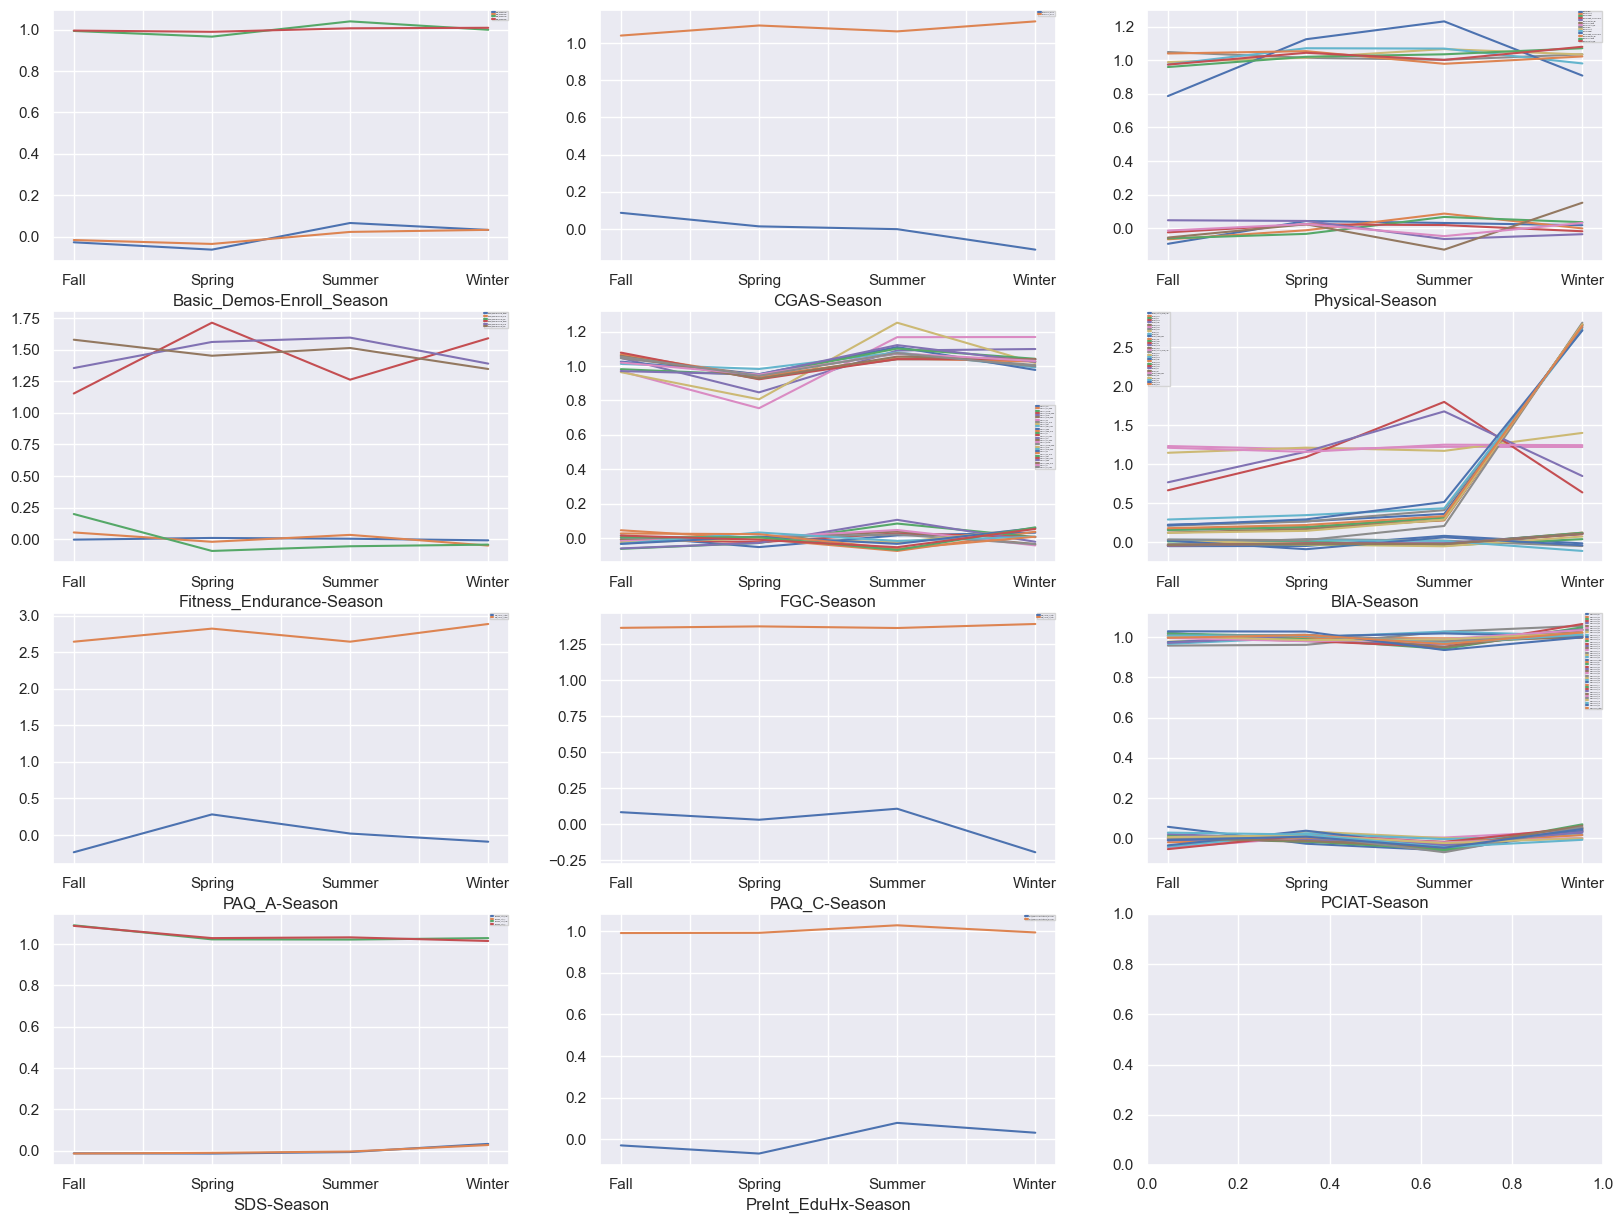

In [ ]:
# analysis distribution of attributes based on corresponding seasons.
# assuming normal distribution

# all prefix
prefix_ls = ['Basic_Demos', 'CGAS', 'Physical', 'Fitness_Endurance', 
             'FGC', 'BIA', 'PAQ_A', 'PAQ_C', 'PCIAT', 'SDS', 'PreInt_EduHx']

def mean_normalization(df):
    return (df-df.mean())/df.std()

fig, axs = plt.subplots(4,3)

# to inspect values groupby season with mean and sd exceeding threshold
threshold = 0.1
counter = 0
for p in prefix_ls:
    # print(train.columns)
    p_col = [col for col in train.columns if col.startswith(p)]
    p_df = train[p_col]
    groupby_col = [col for col in p_col if col.endswith('Season')]
    
    normalization_df = p_df.drop(columns=groupby_col)
    normalization_df = normalization_df.fillna(normalization_df.mean())
    normalization_df = mean_normalization(normalization_df)
    p_df.loc[:,normalization_df.columns] = normalization_df

    g_p_col = p_df.groupby(groupby_col)
    average = g_p_col.mean()
    sd = g_p_col.std()

    i = counter // 3
    j = counter % 3
    average.plot(ax=axs[i, j])
    sd.plot(ax=axs[i, j])
    axs[i, j].legend(fontsize = 0)
    counter += 1

    if (average.abs() > threshold).to_numpy().any():
        print(average)
    if ((sd - 1).abs() > threshold).to_numpy().any():
        print(sd)

In [3]:
numeric_data = train.select_dtypes(include=['number'])
print(numeric_data.shape[1])
categorical_data = train.select_dtypes(exclude=['number'])
print(categorical_data.shape[1])
cat_data = train.filter(regex='Zone|sii|Age')
float_data = train.select_dtypes(include=['float64'])
#continnum_data = continnum_data.loc[:, ~float_data.columns.str.contains('PCIAT|Zone')]
continnum_data = float_data.loc[:, ~float_data.columns.str.contains('PCIAT|Zone')]

70
12


In [4]:
continnum_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CGAS-CGAS_Score                         2342 non-null   float64
 1   Physical-BMI                            2527 non-null   float64
 2   Physical-Height                         2530 non-null   float64
 3   Physical-Weight                         2572 non-null   float64
 4   Physical-Waist_Circumference            483 non-null    float64
 5   Physical-Diastolic_BP                   2478 non-null   float64
 6   Physical-HeartRate                      2486 non-null   float64
 7   Physical-Systolic_BP                    2478 non-null   float64
 8   Fitness_Endurance-Max_Stage             731 non-null    float64
 9   Fitness_Endurance-Time_Mins             728 non-null    float64
 10  Fitness_Endurance-Time_Sec              728 non-null    float64
 

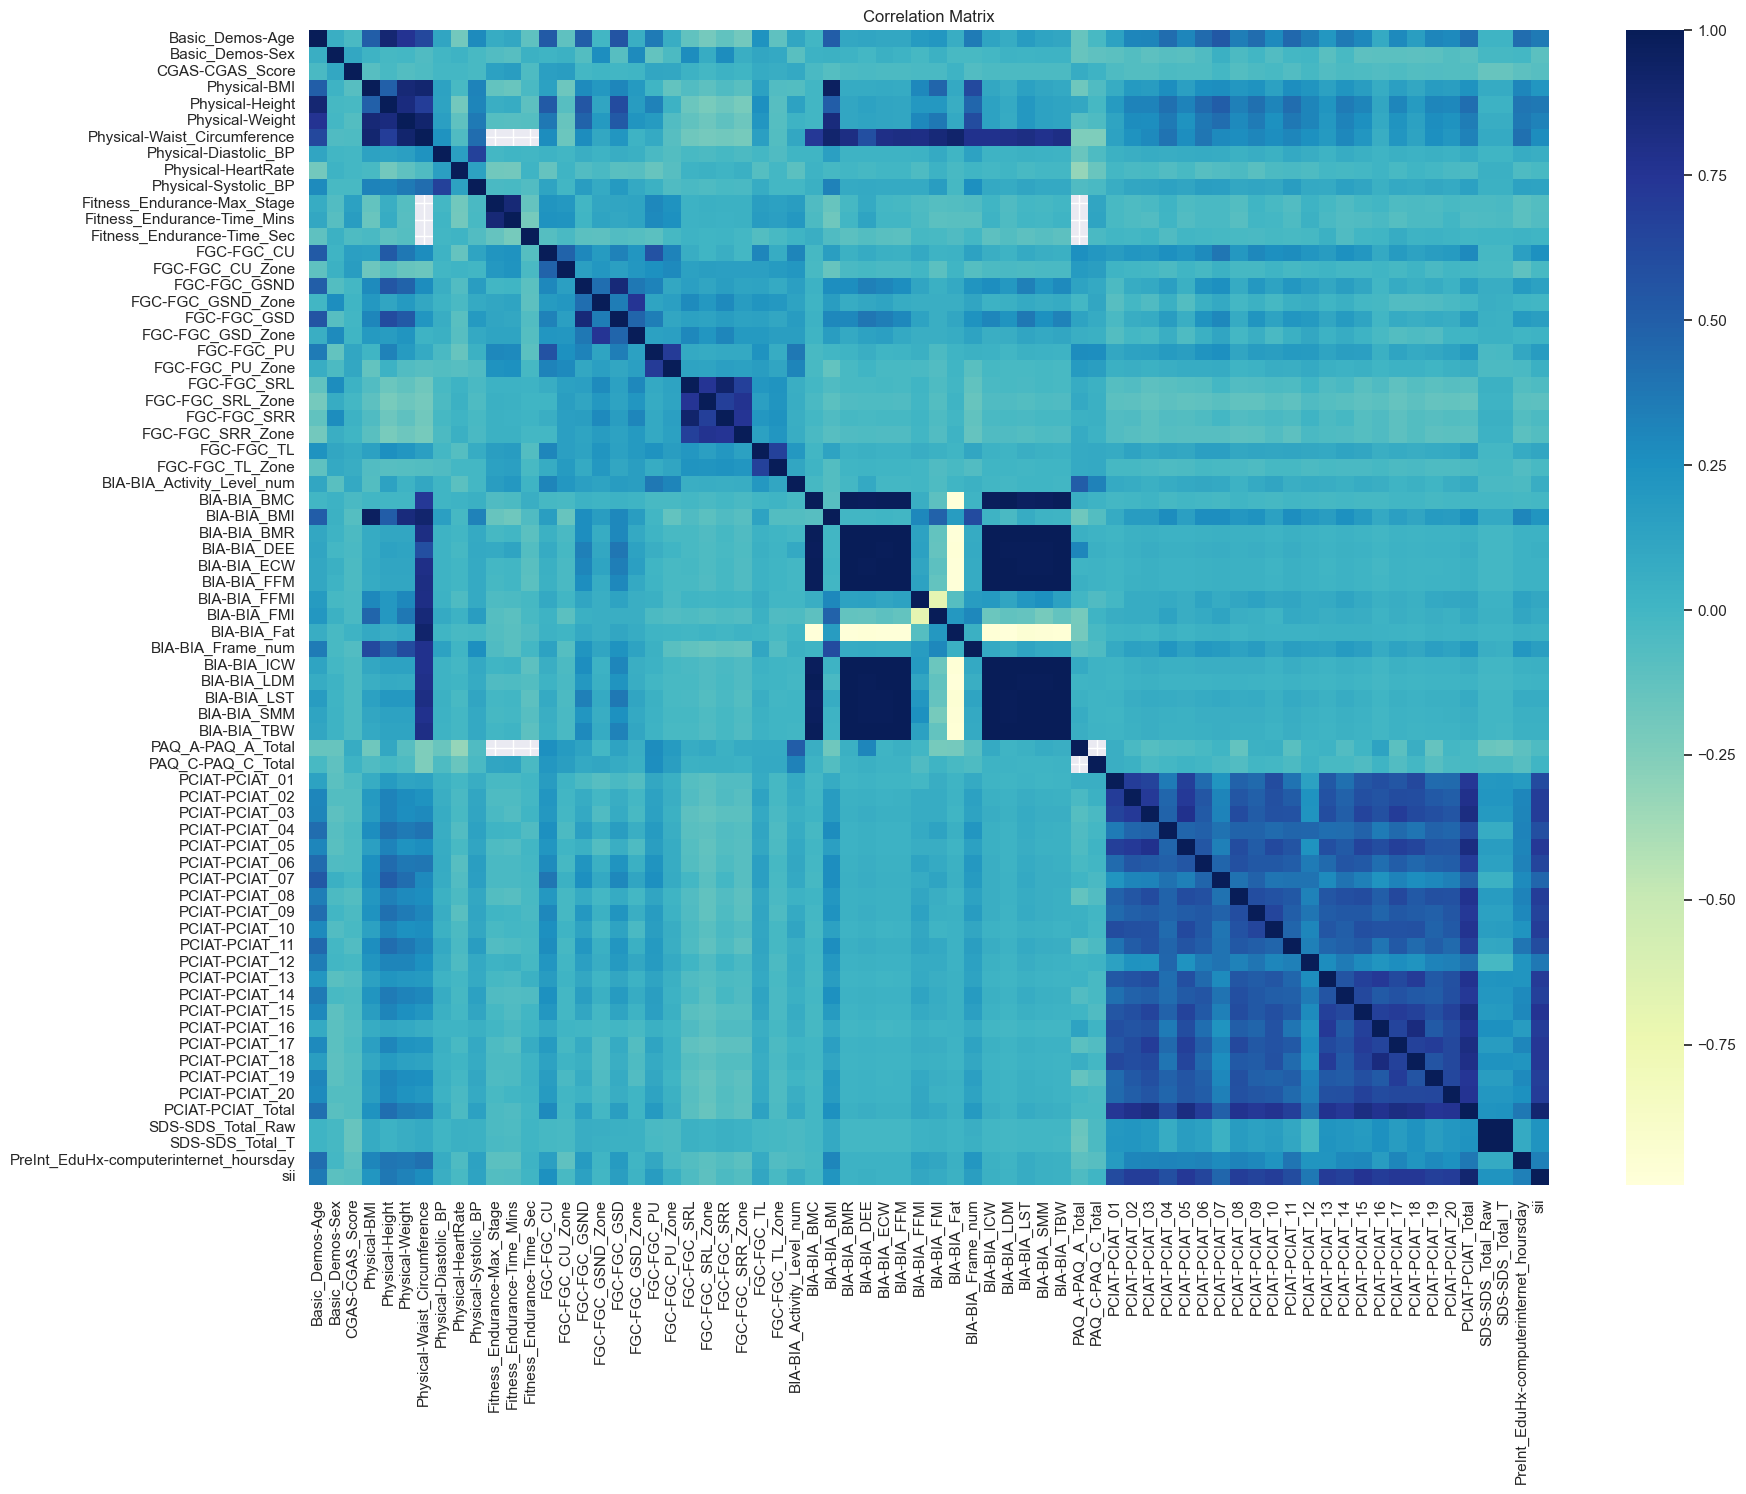

In [5]:
#matrix = numeric_data.corr()
#matrix.to_excel("Corrmat.xlsx", sheet_name='Corrmat')

# plt.imshow(matrix, cmap='Blues')

# plt.colorbar()

# variables = matrix.columns.tolist()
# plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
# plt.yticks(range(len(matrix)), variables)
sns.set (rc = {'figure.figsize':(20, 15)})
plt1 = sns.heatmap(numeric_data.corr(), cmap='YlGnBu', annot=False)
plt1.set_title('Correlation Matrix')
fig = plt1.get_figure()
fig.savefig("correlation_all.png")


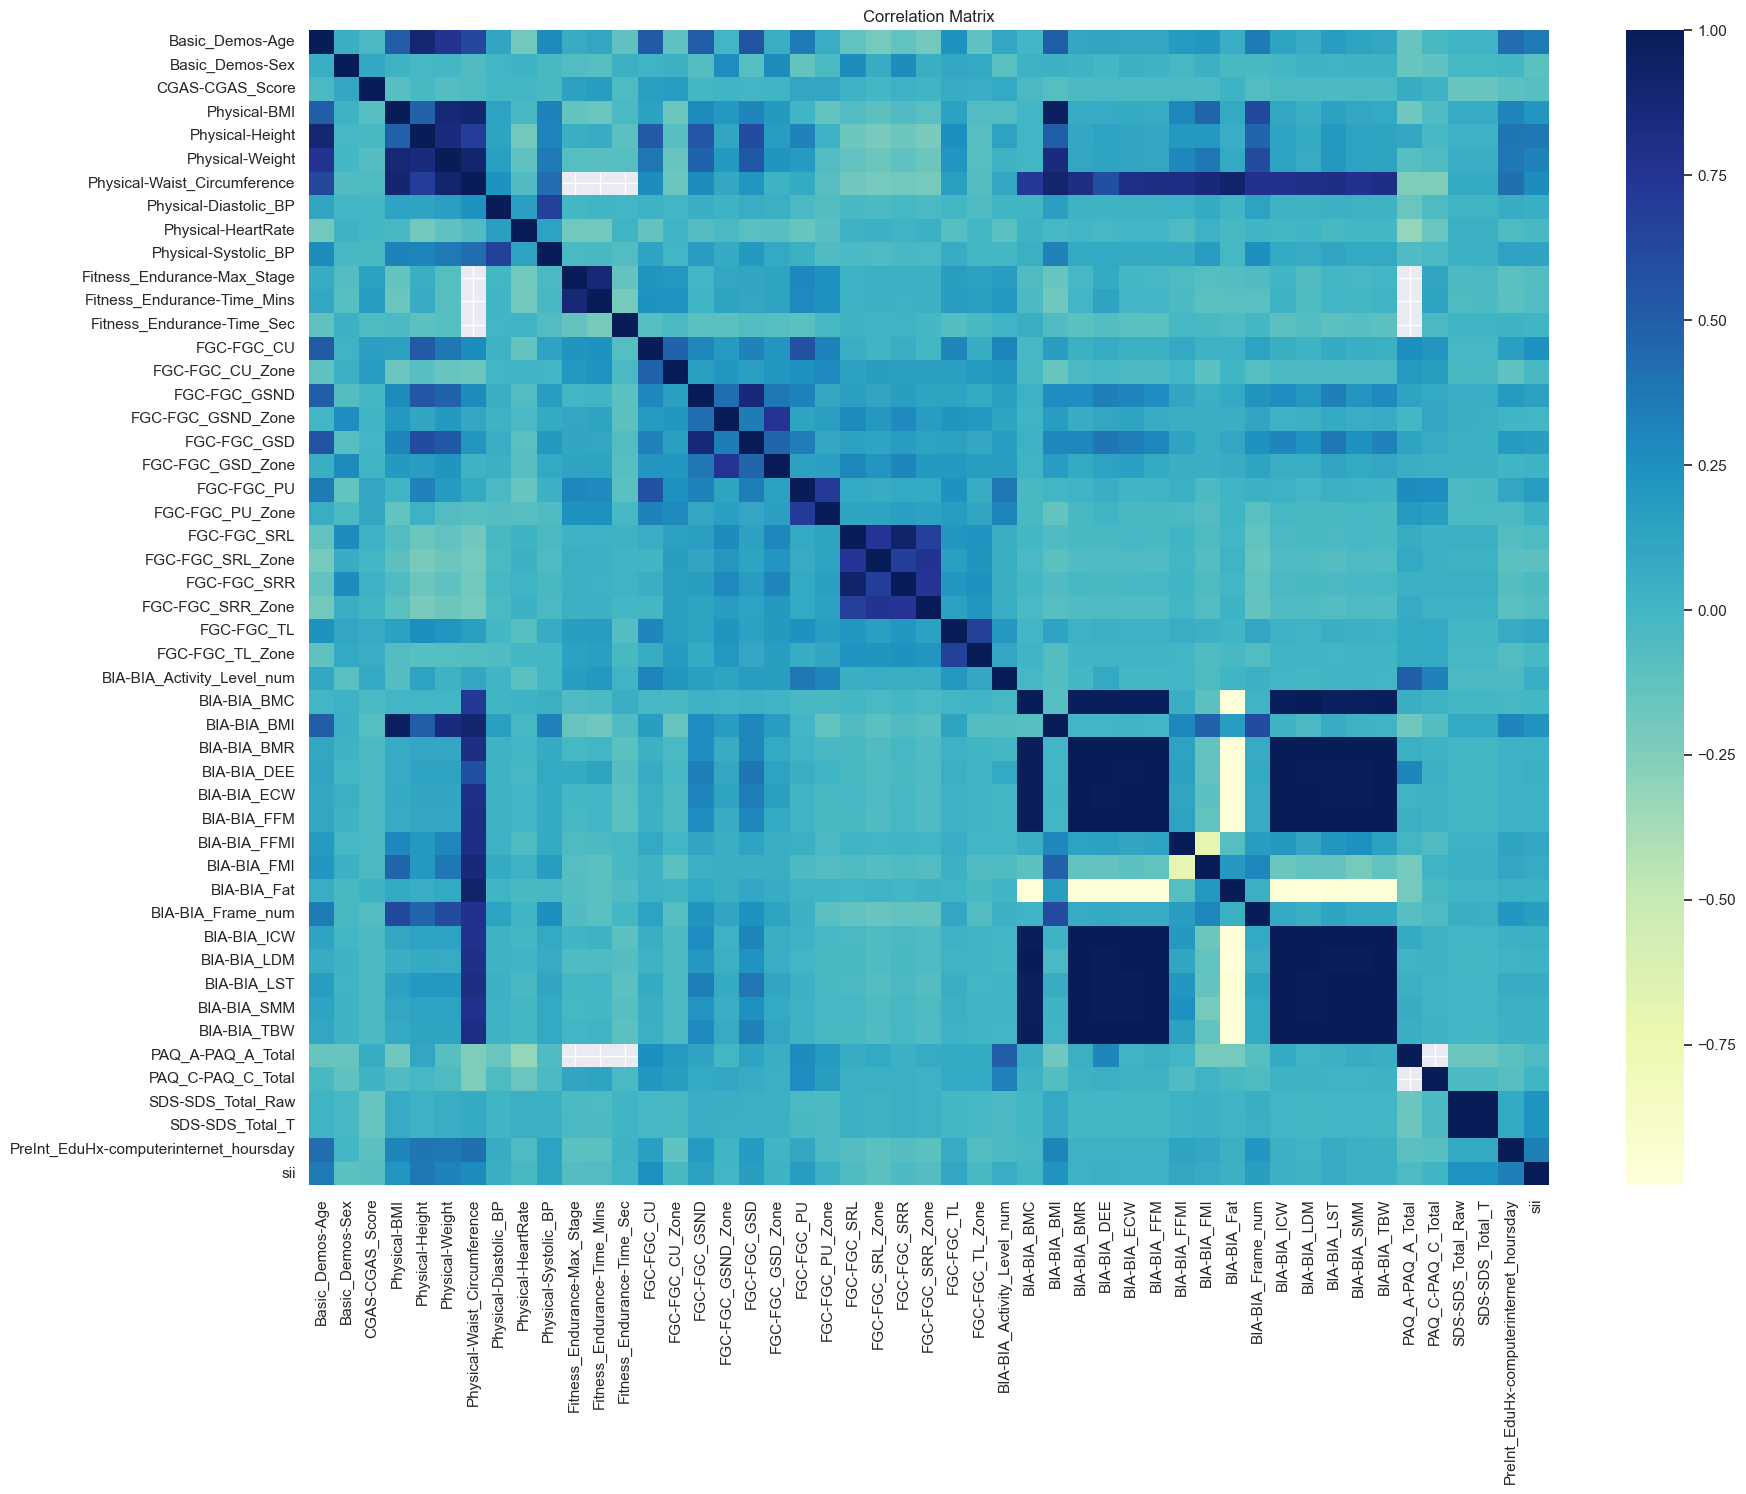

In [6]:
excludePCIAT= numeric_data.loc[:, ~numeric_data.columns.str.contains('PCIAT')]
sns.set (rc = {'figure.figsize':(20, 15)})
plt1 = sns.heatmap(excludePCIAT.corr(), cmap='YlGnBu', annot=False)
plt1.set_title('Correlation Matrix')
fig = plt1.get_figure()
fig.savefig("excludePCIAT.png")

In [7]:
matrix = numeric_data.corr()
matrix_abs = matrix.abs()
sorted_mat = matrix_abs.unstack().sort_values(ascending=False) 
df_sorted_mat = sorted_mat.reset_index()
df_sorted_mat.columns = ['v1', 'v2', 'correlation']
df_sorted_mat = df_sorted_mat[df_sorted_mat['v1'] != df_sorted_mat['v2']]
df_sorted_mat.to_excel("Corrmat_abs.xlsx", sheet_name='Corrmat_abs', index=False)

In [8]:
selected_columns = pd.read_excel("data_dictionary.xlsx")
selected_columns = selected_columns[selected_columns['Selected'] == 'Y']
Field = selected_columns['Field'].tolist()
print (Field)

['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'BIA-BIA_BMI', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii']


In [9]:
selected_var = numeric_data[Field]
print(selected_var.columns.tolist())

['Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'BIA-BIA_BMI', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii']


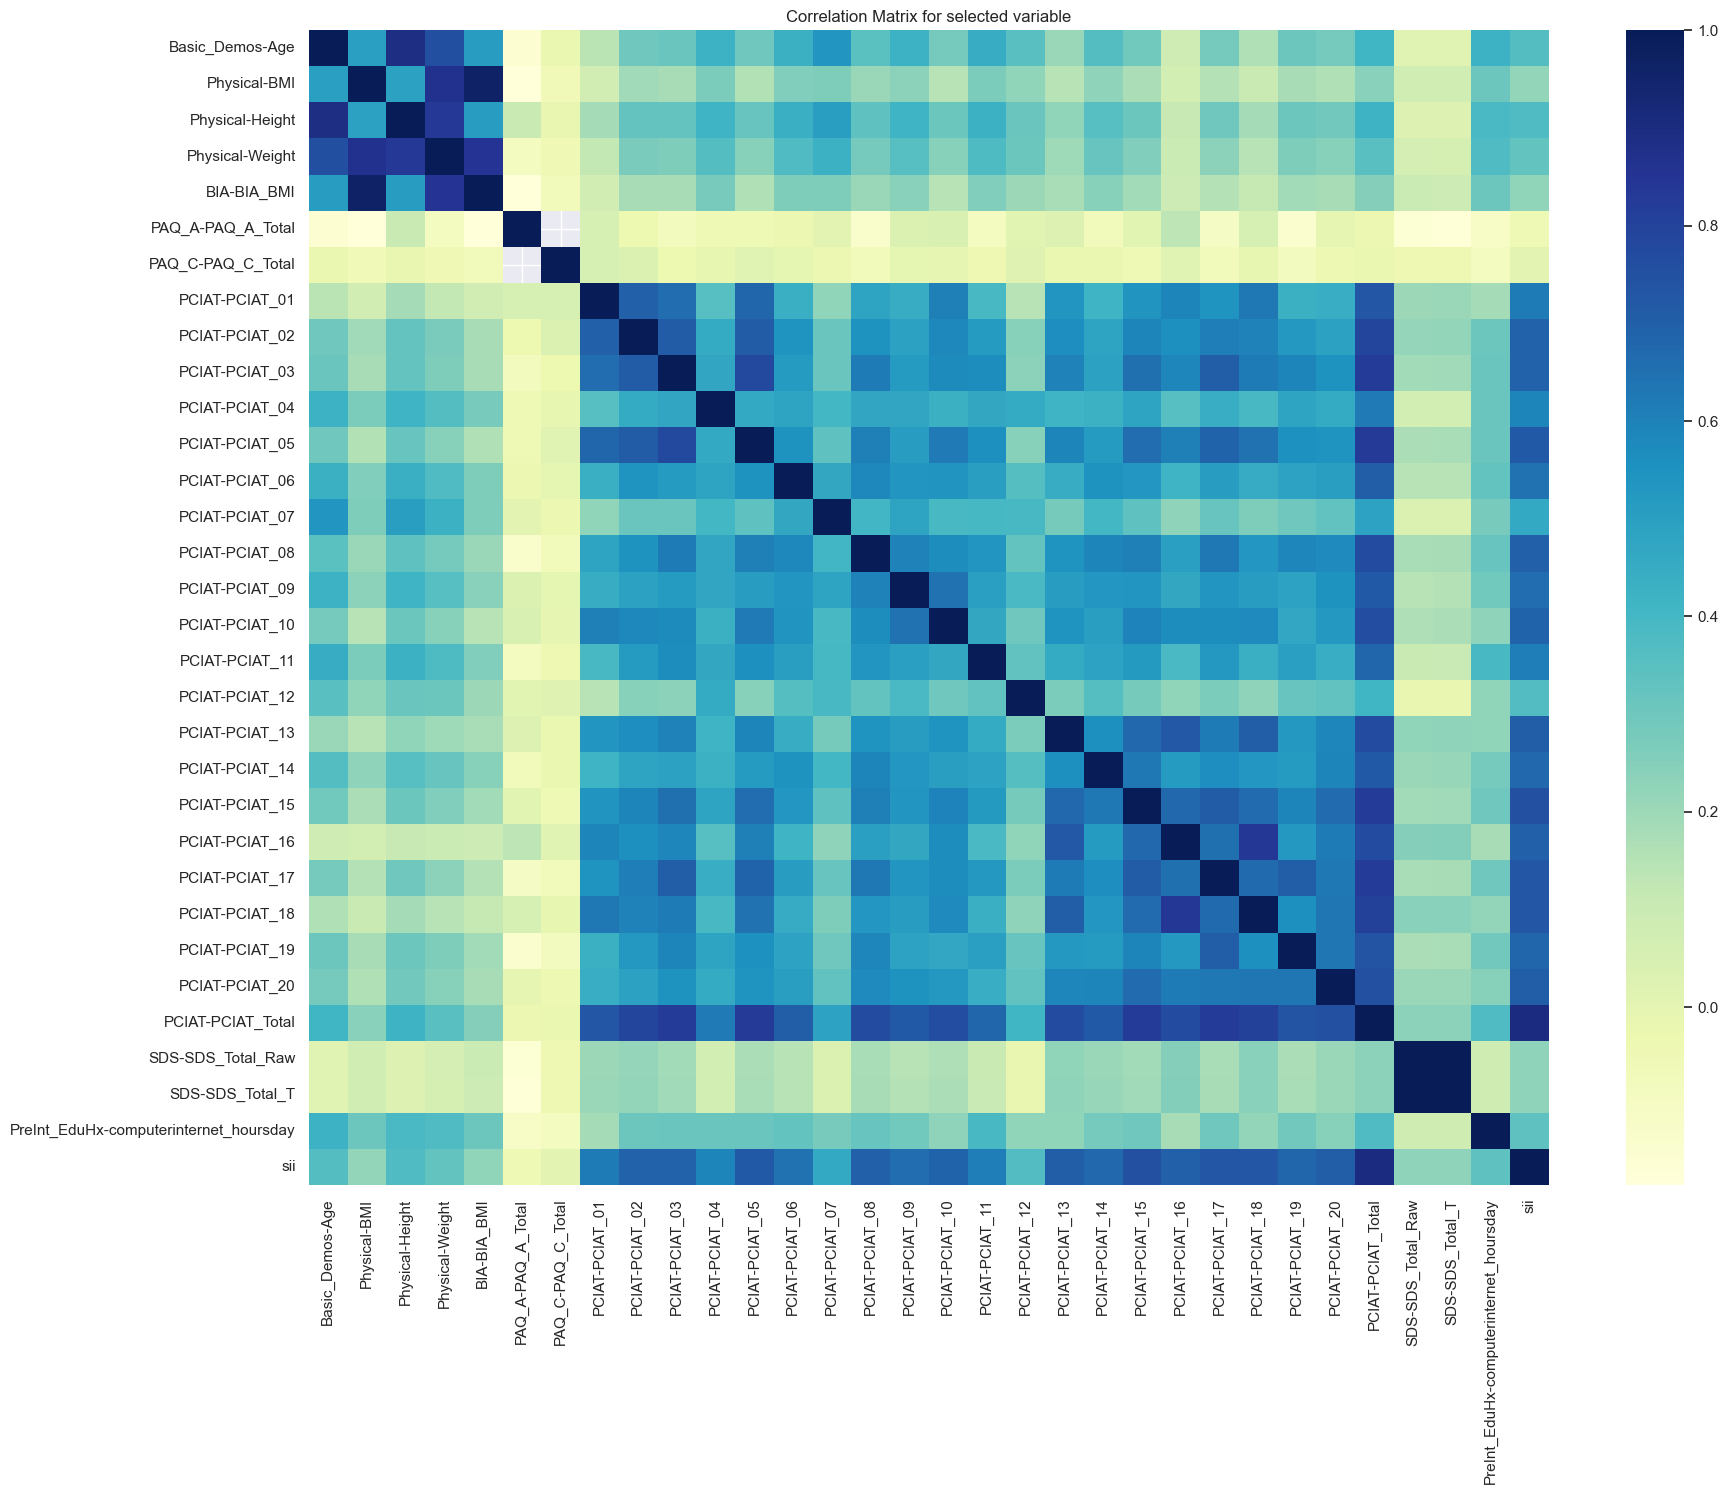

In [10]:
#After filter manually

#matrix = selected_var.corr()
# matrix.to_excel("Corrmat.xlsx", sheet_name='Corrmat')
# matrix_abs = matrix.abs()
# matrix_abs.to_excel("Corrmat_abs.xlsx", sheet_name='Corrmat')
# plt.imshow(matrix, cmap='Blues')

# plt.colorbar()

# variables = matrix.columns.tolist()
# plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
# plt.yticks(range(len(matrix)), variables)

# plt.title('Correlation Matrix')
# plt.show()

plt2 = sns.heatmap(selected_var.corr(), cmap='YlGnBu', annot=False)
plt2.set_title('Correlation Matrix for selected variable')
fig2 = plt2.get_figure()
fig2.savefig("correlation_selected.png")

In [11]:
from sklearn.decomposition import PCA

In [12]:
from scipy import stats
PCIAT_sii = train[['PCIAT-PCIAT_Total', 'sii']].dropna()
print(PCIAT_sii.describe())
correlation_coefficient, p_value = stats.pearsonr(train['PCIAT-PCIAT_Total'], train['sii'])
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

       PCIAT-PCIAT_Total          sii
count        2736.000000  2736.000000
mean           27.896199     0.580409
std            20.338853     0.771122
min             0.000000     0.000000
25%            12.000000     0.000000
50%            26.000000     0.000000
75%            41.000000     1.000000
max            93.000000     3.000000
Pearson correlation coefficient: 0.8996812484259727
P-value: 0.0


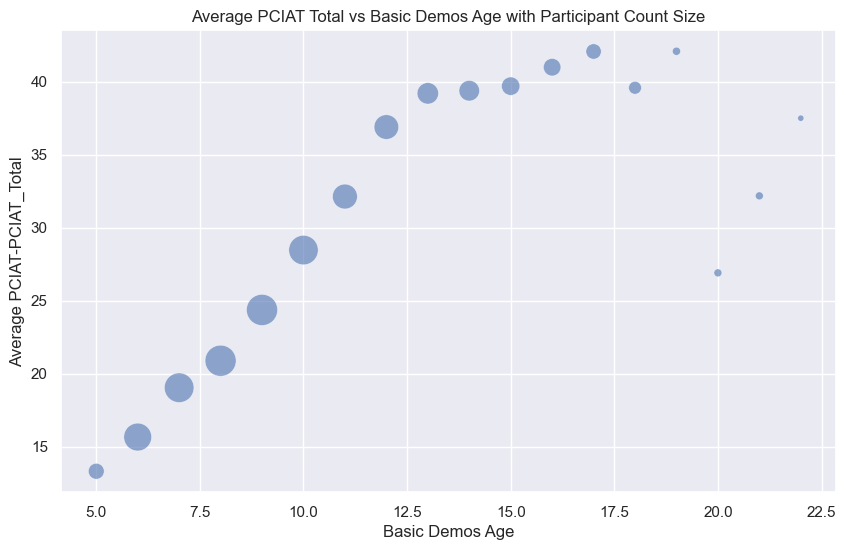

In [13]:
age_stats = train.groupby('Basic_Demos-Age').agg(
    Average_PCIAT_Total=('PCIAT-PCIAT_Total', 'mean'),
    Participant_Count=('Basic_Demos-Age', 'size')).reset_index()

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x="Basic_Demos-Age",  
    y="Average_PCIAT_Total", 
    data=age_stats, 
    size="Participant_Count",  
    sizes=(20, 500), 
    alpha=0.6,  
    legend=None )

plt.title('Average PCIAT Total vs Basic Demos Age with Participant Count Size')
plt.xlabel('Basic Demos Age')
plt.ylabel('Average PCIAT-PCIAT_Total')
plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\2484441200.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train, palette='YlGnBu')


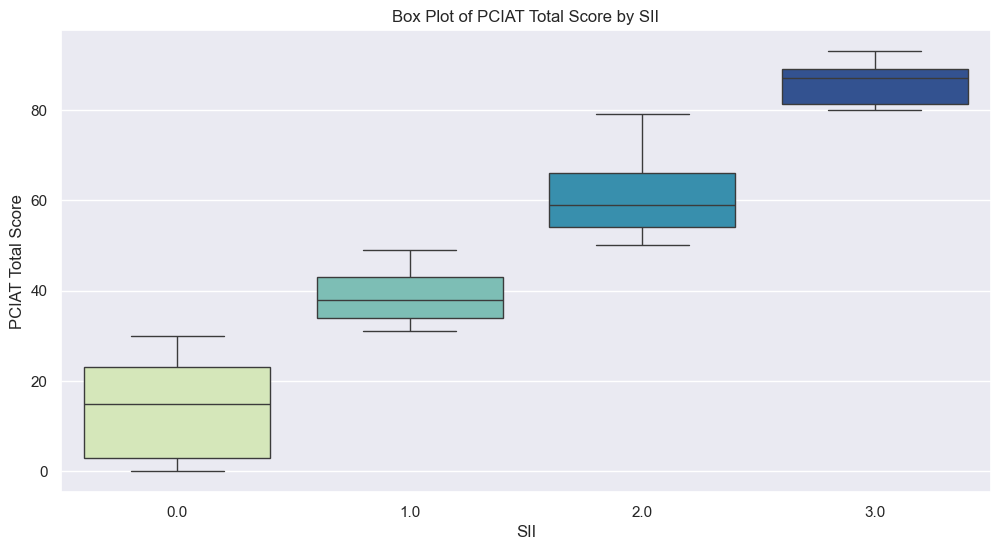

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train, palette='YlGnBu')
plt.title('Box Plot of PCIAT Total Score by SII')
plt.xlabel('SII')
plt.ylabel('PCIAT Total Score')
plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\2519111655.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Age Group', title_fontsize='13', fontsize='11')


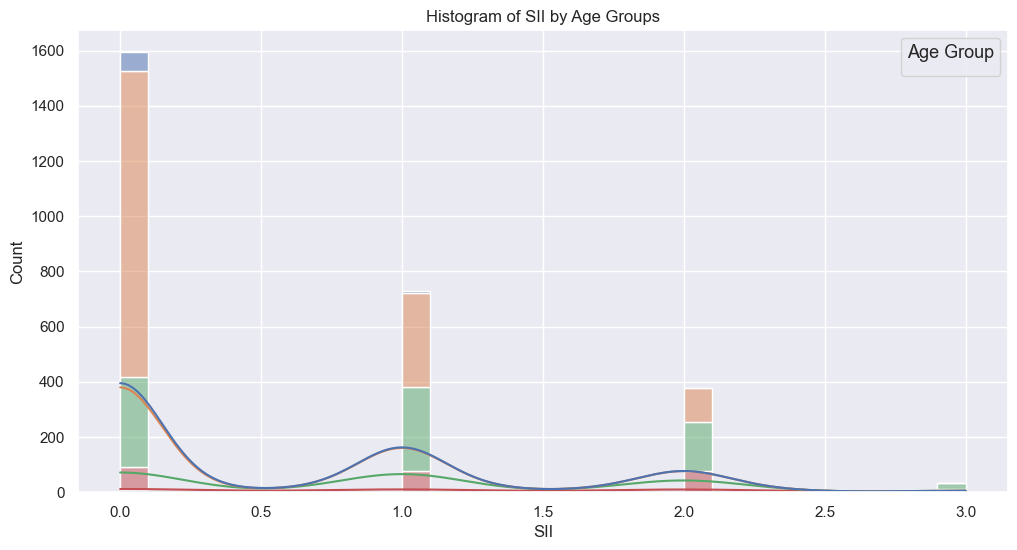

In [15]:
bins = [0, 5, 10, 15, 20, 25]  # Adjust bins as needed
labels = ['0-5', '6-10', '11-15', '16-20', '21-25']
train['Age_Group'] = pd.cut(train['Basic_Demos-Age'], bins=bins, labels=labels)

# Plotting the histogram of 'sii' for different age groups
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='sii', hue='Age_Group', multiple='stack', bins=30, kde=True)

# Adding title and labels
plt.title('Histogram of SII by Age Groups')
plt.xlabel('SII')
plt.ylabel('Count')

# Display the legend
plt.legend(title='Age Group', title_fontsize='13', fontsize='11')

plt.grid(True)
plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\2941573561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y='Basic_Demos-Age',data=train, palette='YlGnBu')


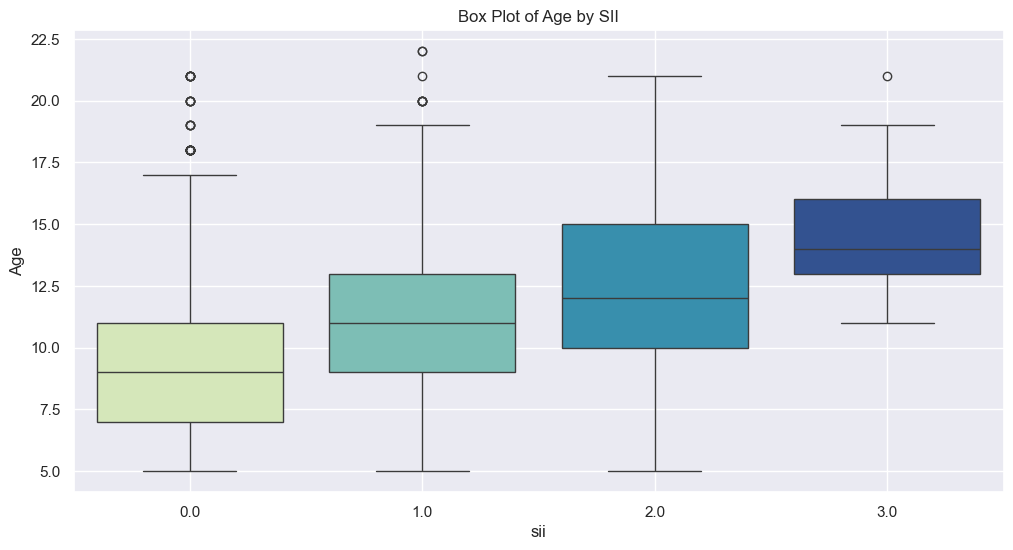

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sii', y='Basic_Demos-Age',data=train, palette='YlGnBu')

plt.title('Box Plot of Age by SII')
plt.xlabel('sii')
plt.ylabel('Age')

plt.grid(True)
plt.show()

In [17]:
continnum_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CGAS-CGAS_Score                         2342 non-null   float64
 1   Physical-BMI                            2527 non-null   float64
 2   Physical-Height                         2530 non-null   float64
 3   Physical-Weight                         2572 non-null   float64
 4   Physical-Waist_Circumference            483 non-null    float64
 5   Physical-Diastolic_BP                   2478 non-null   float64
 6   Physical-HeartRate                      2486 non-null   float64
 7   Physical-Systolic_BP                    2478 non-null   float64
 8   Fitness_Endurance-Max_Stage             731 non-null    float64
 9   Fitness_Endurance-Time_Mins             728 non-null    float64
 10  Fitness_Endurance-Time_Sec              728 non-null    float64
 

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


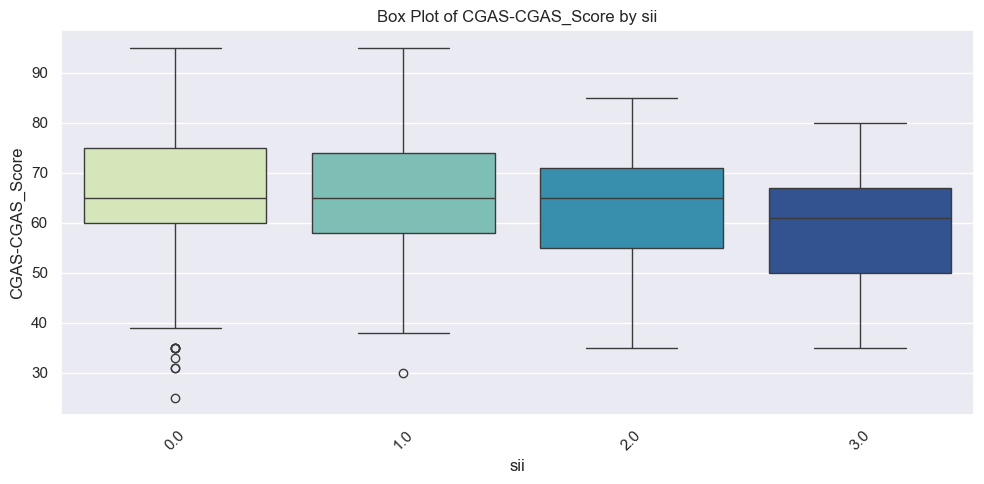

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


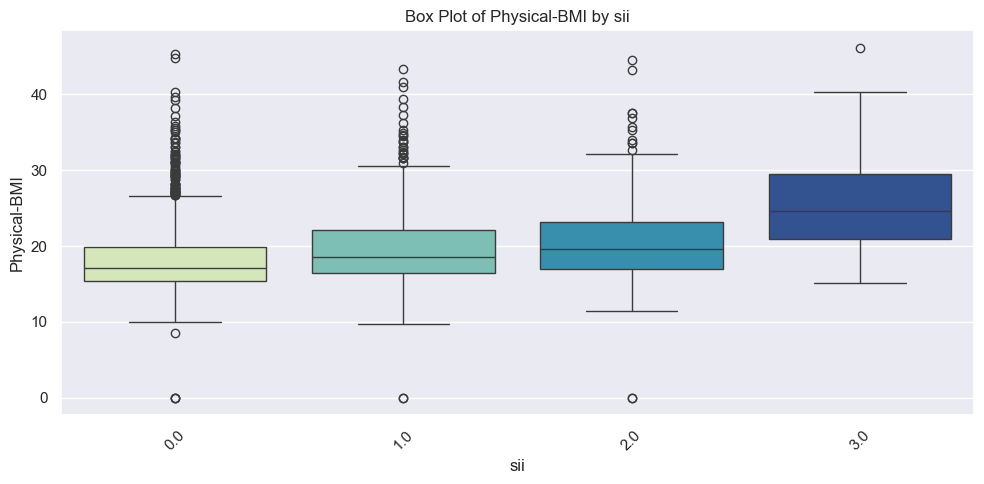

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


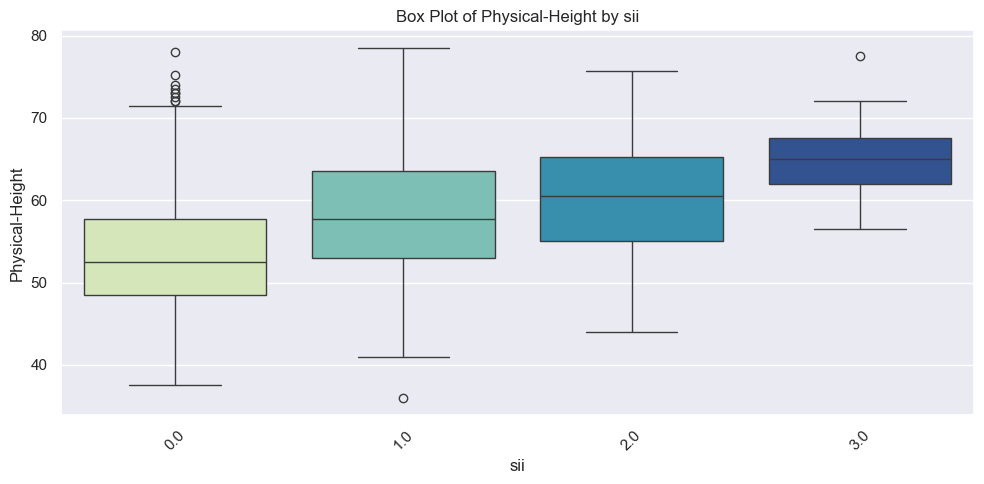

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


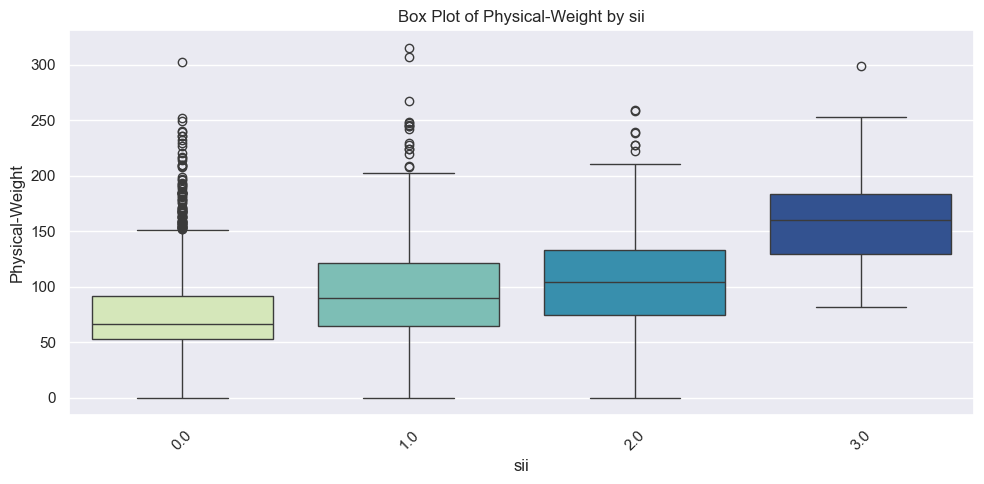

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


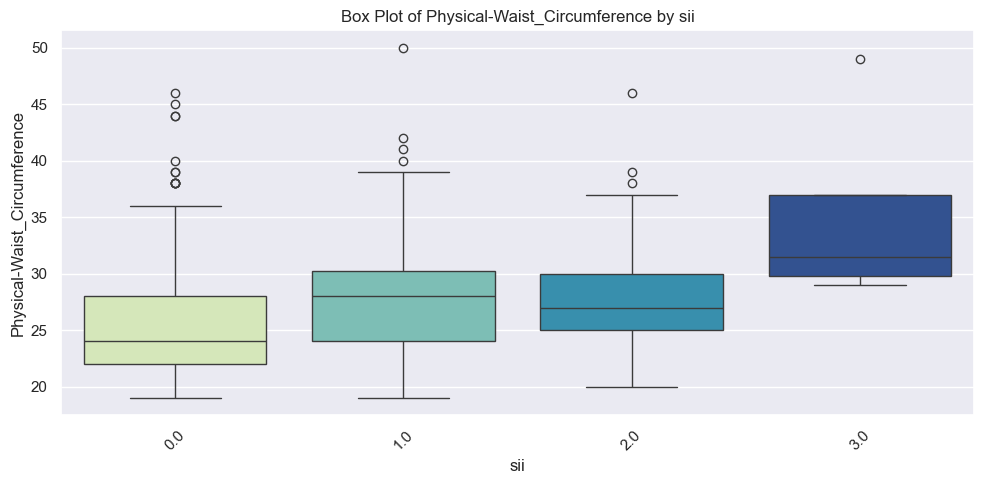

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


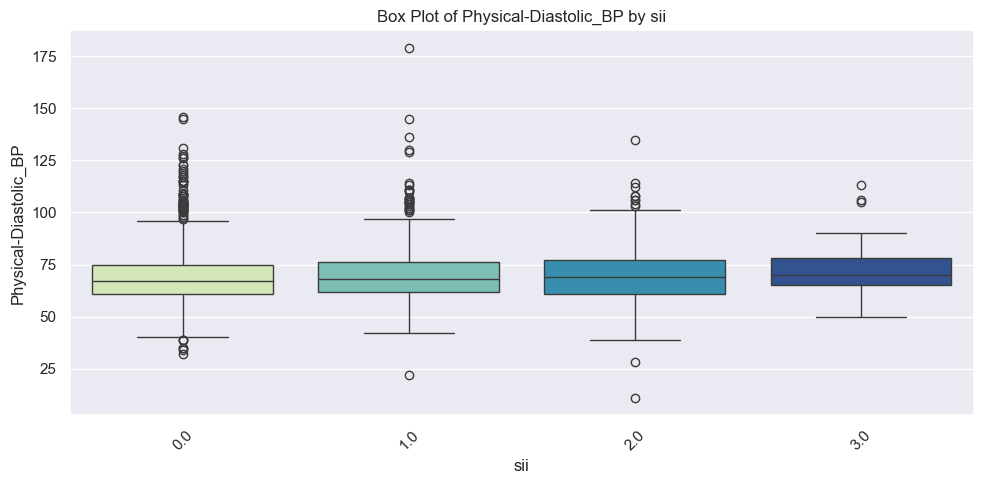

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


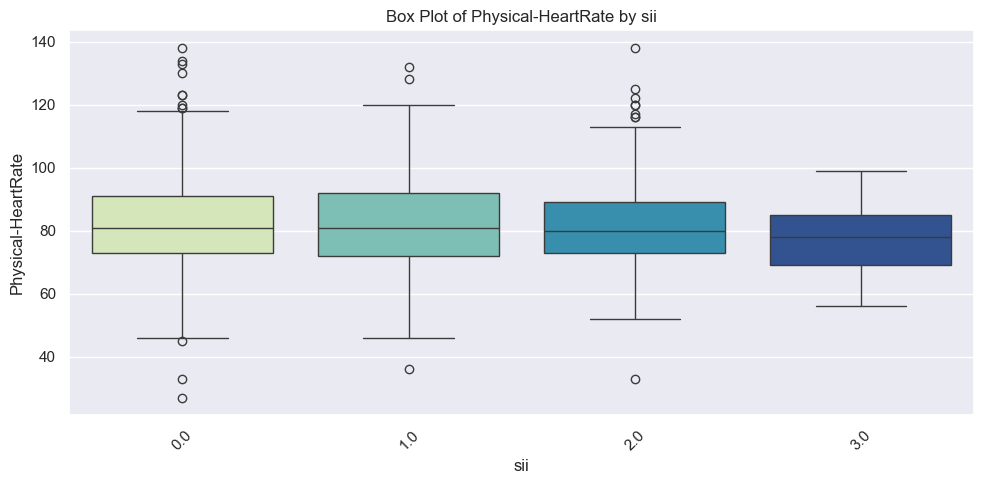

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


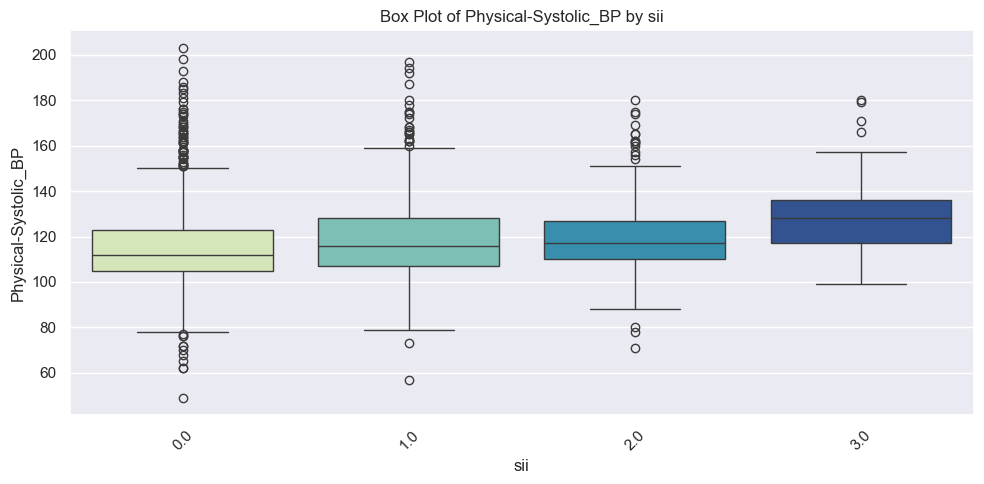

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


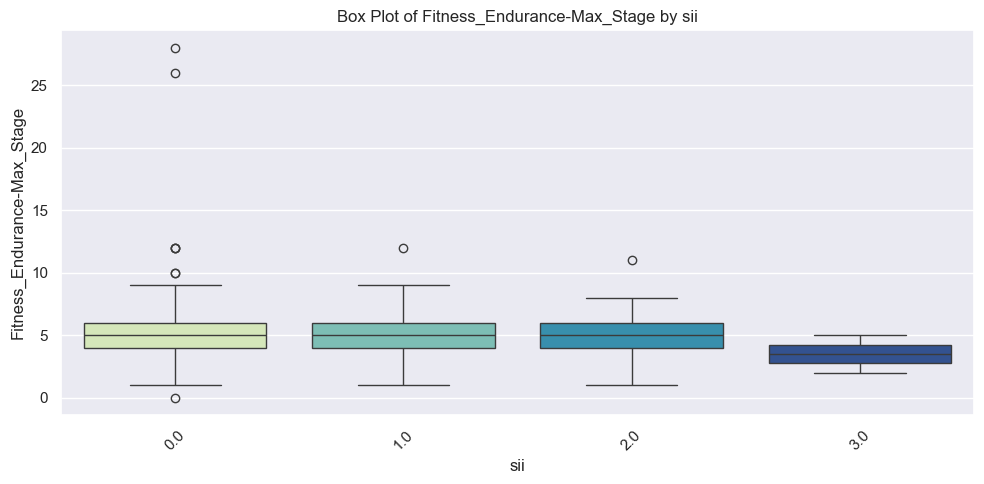

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


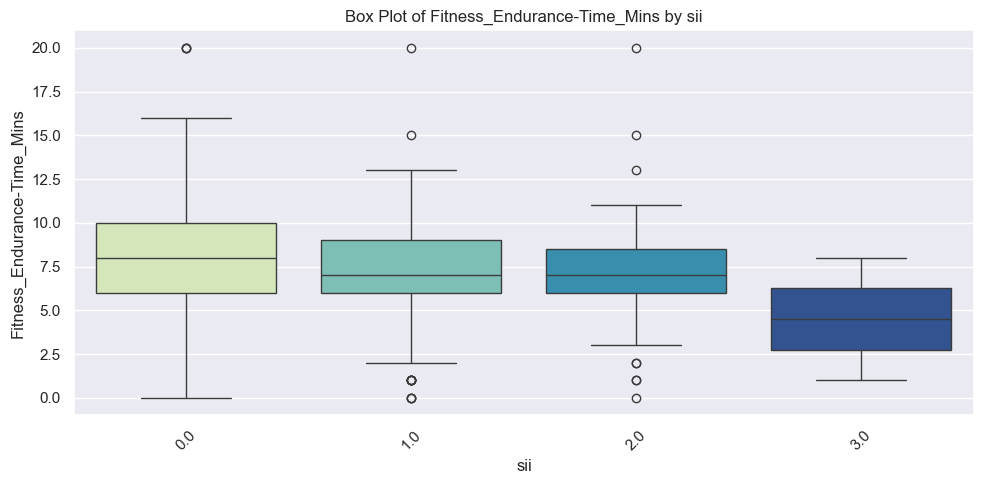

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


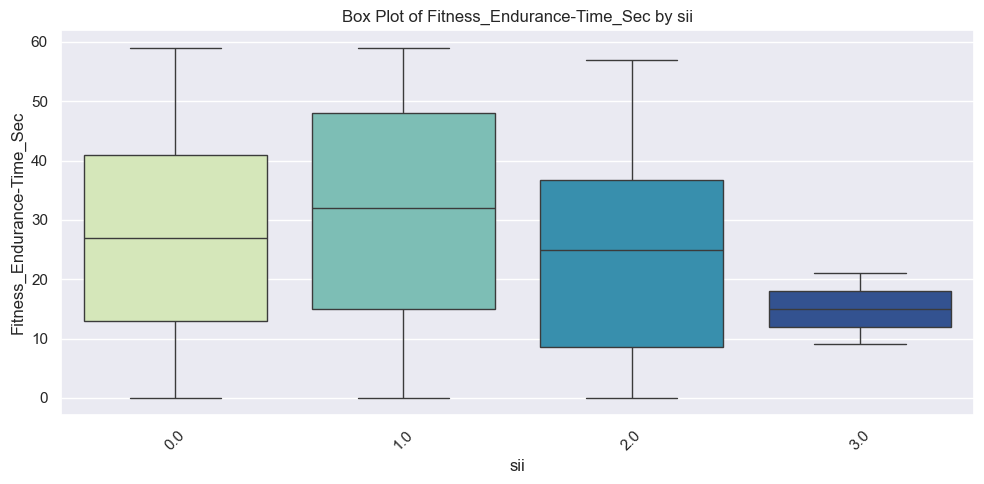

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


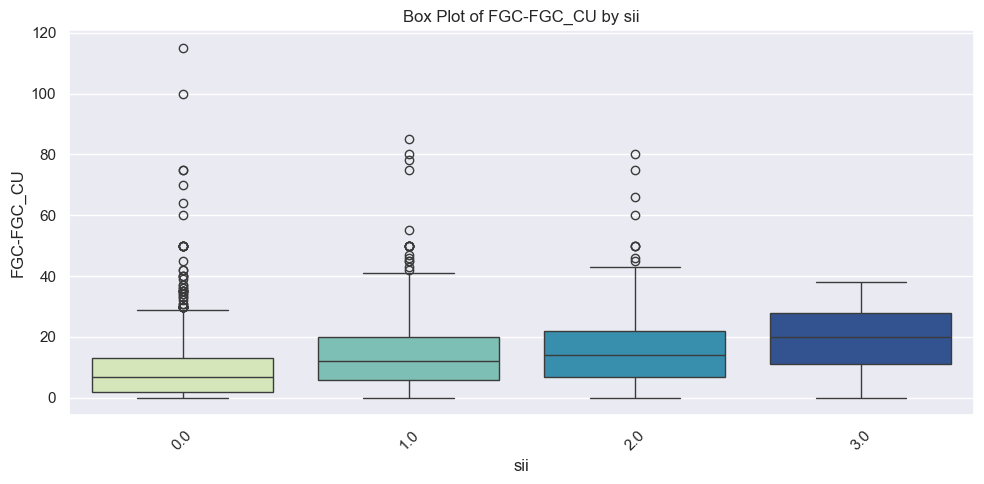

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


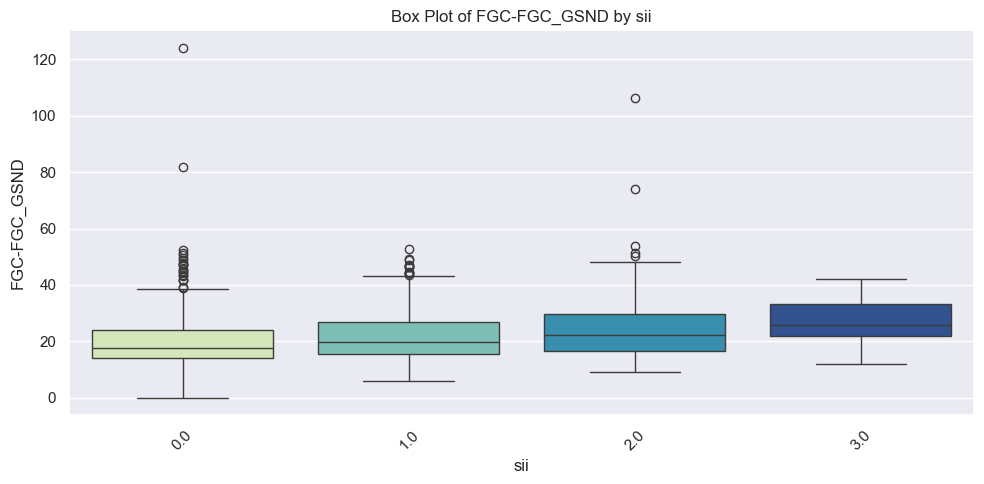

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


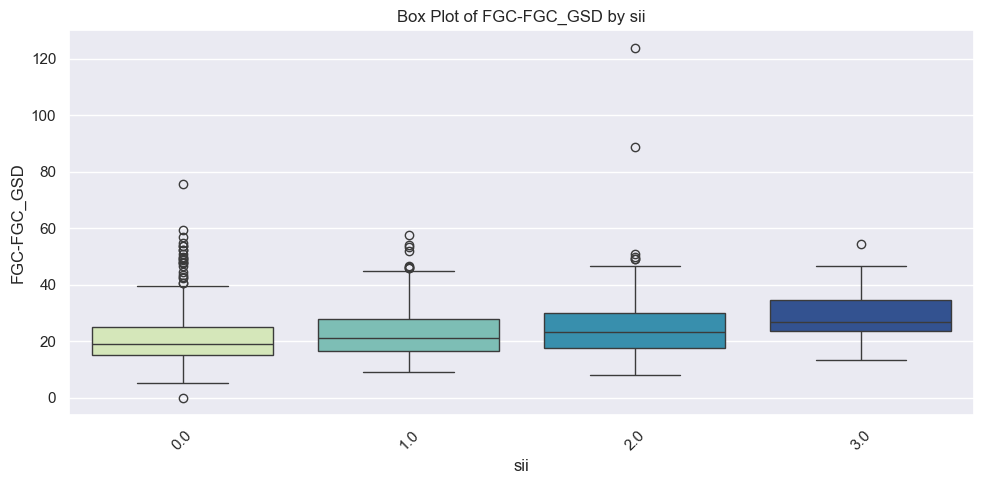

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


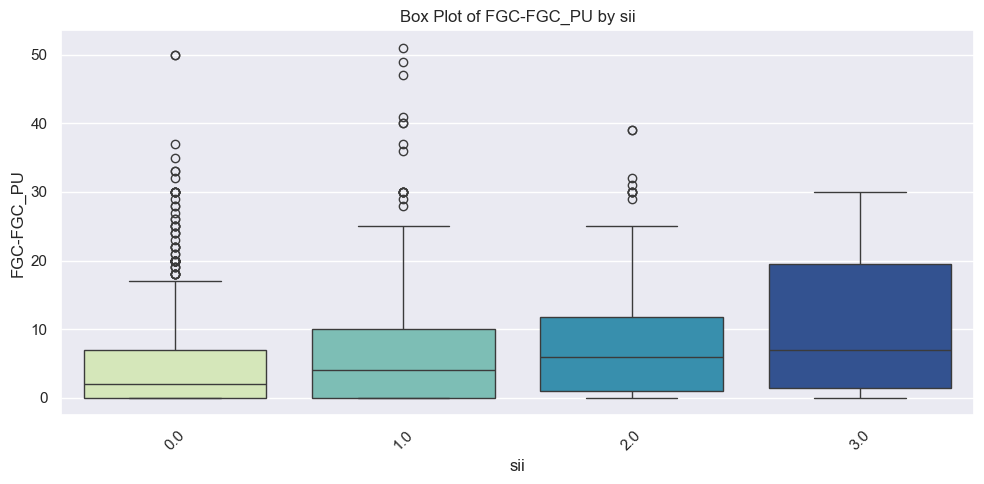

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


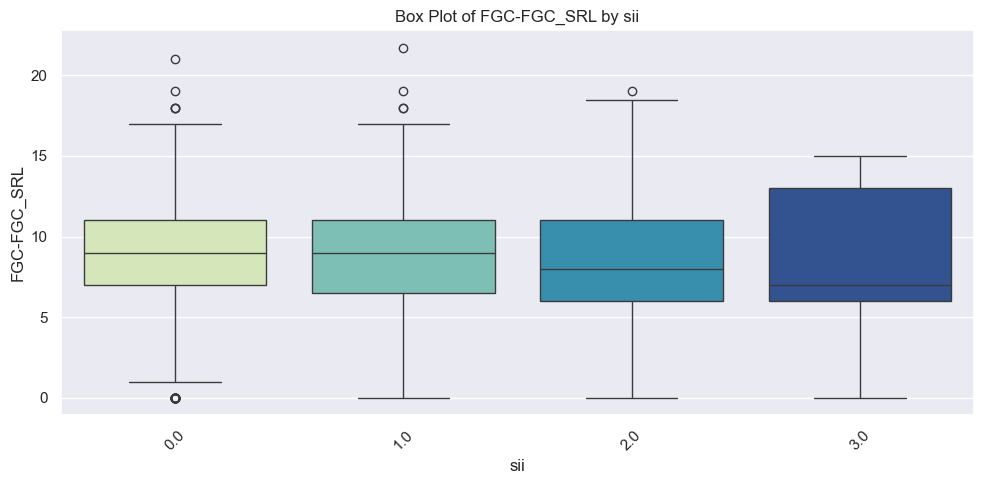

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


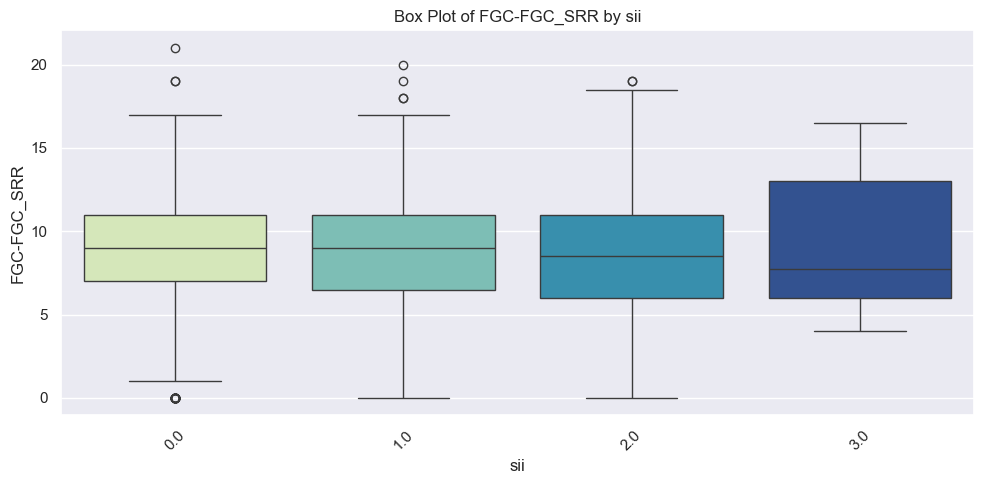

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


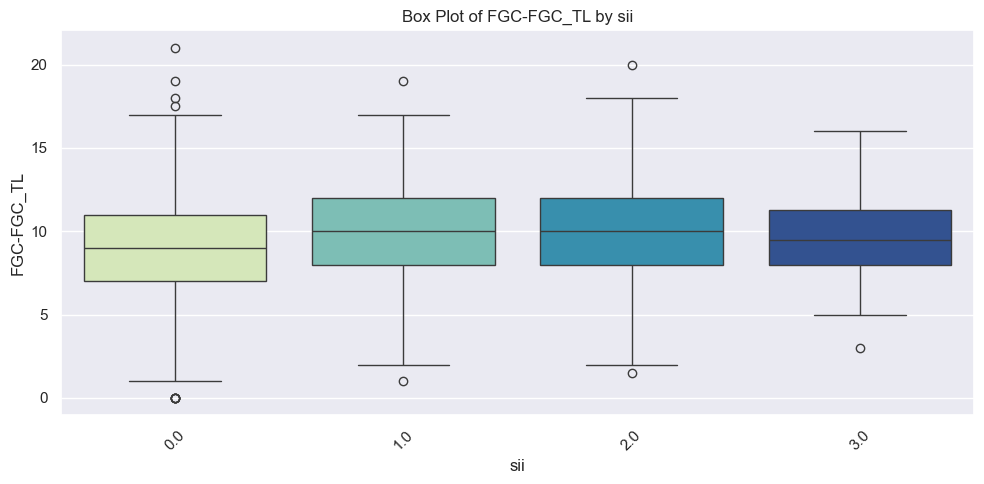

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


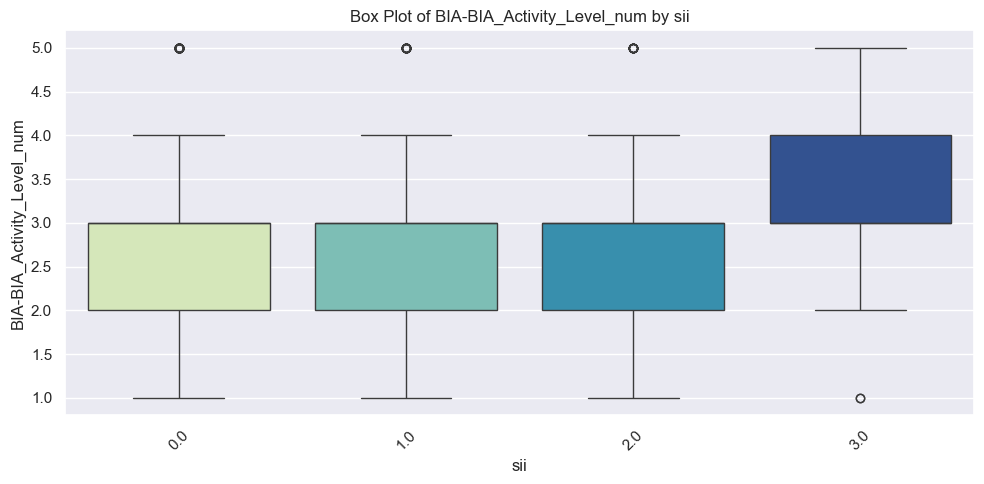

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


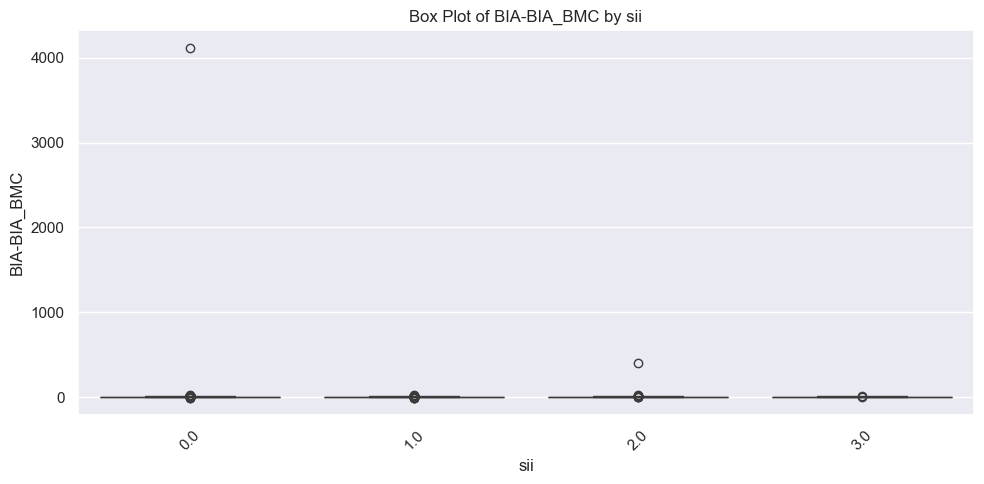

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


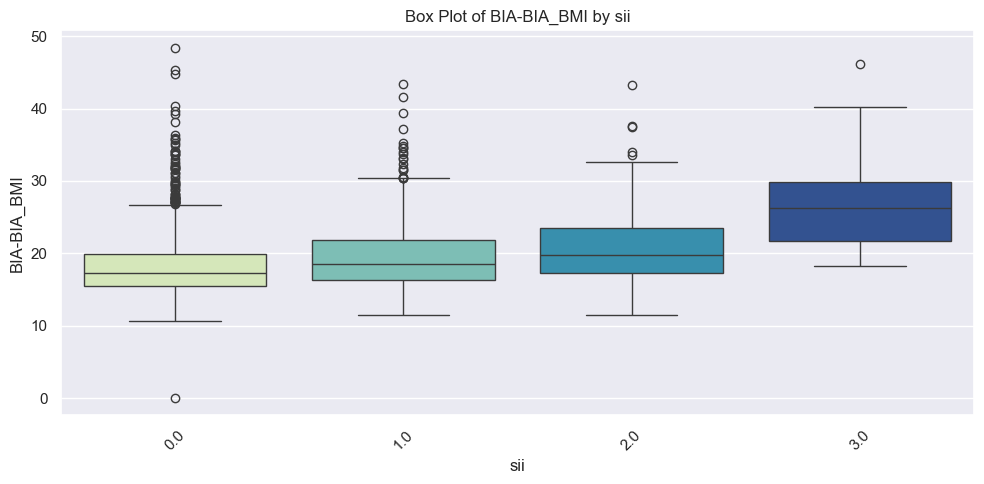

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


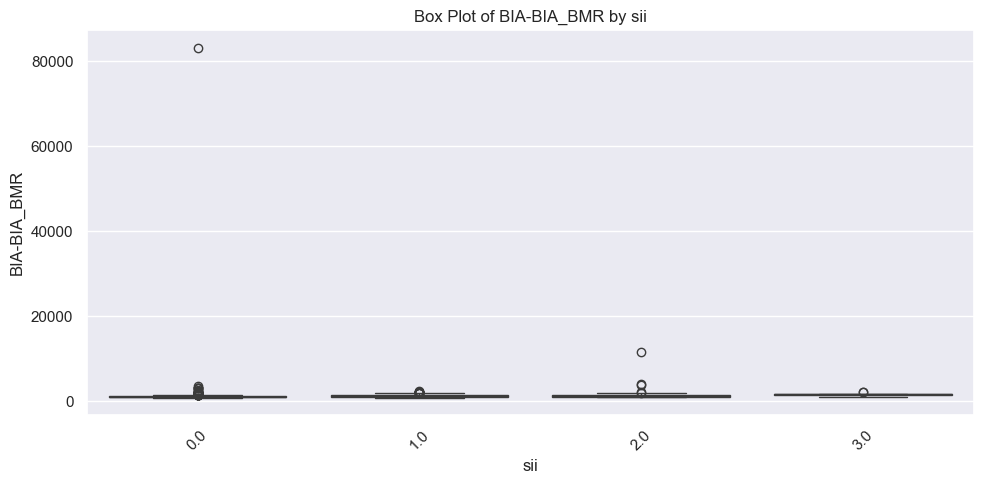

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


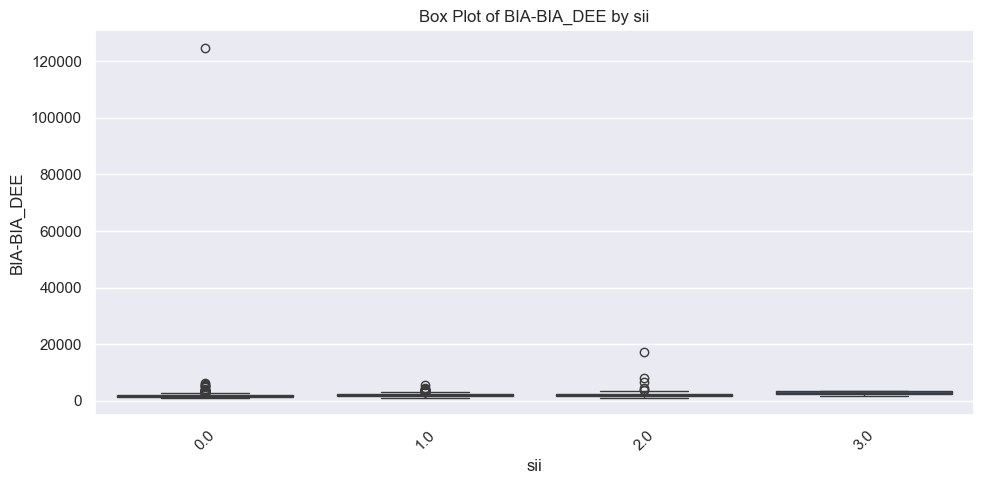

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


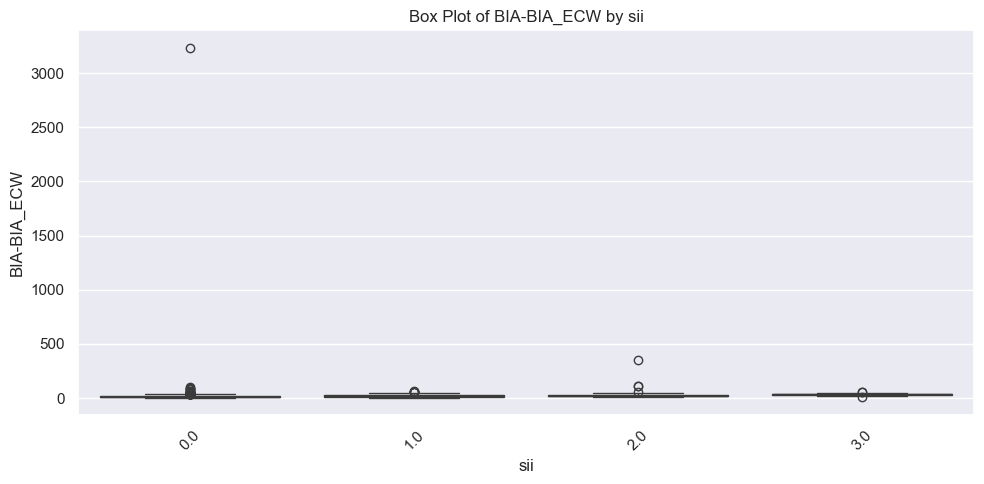

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


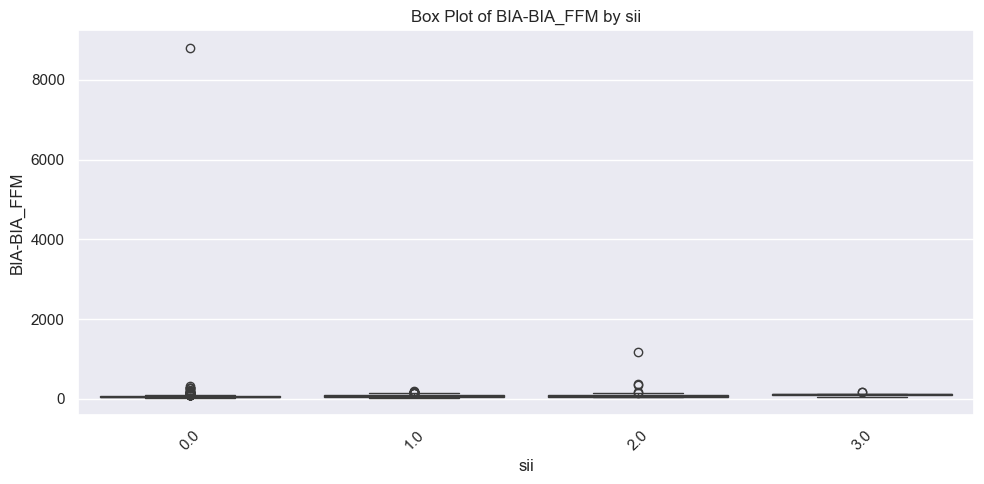

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


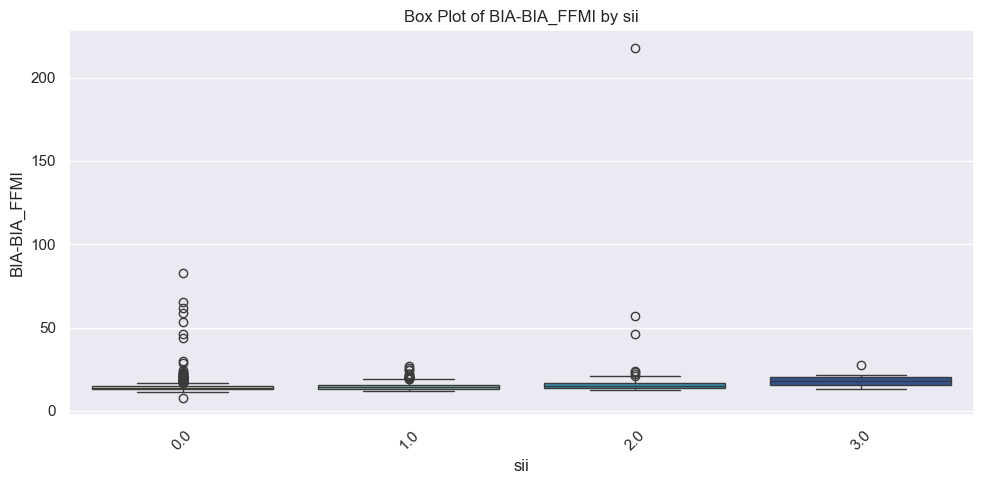

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


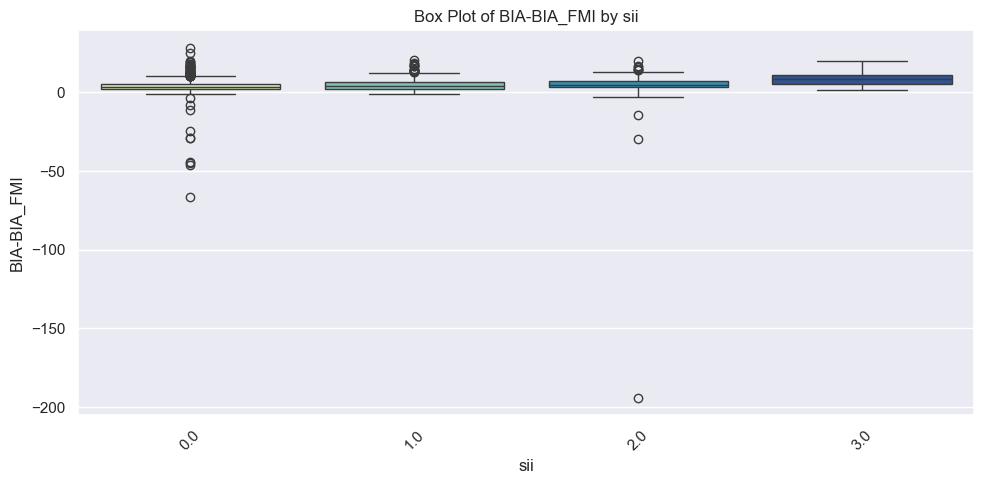

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


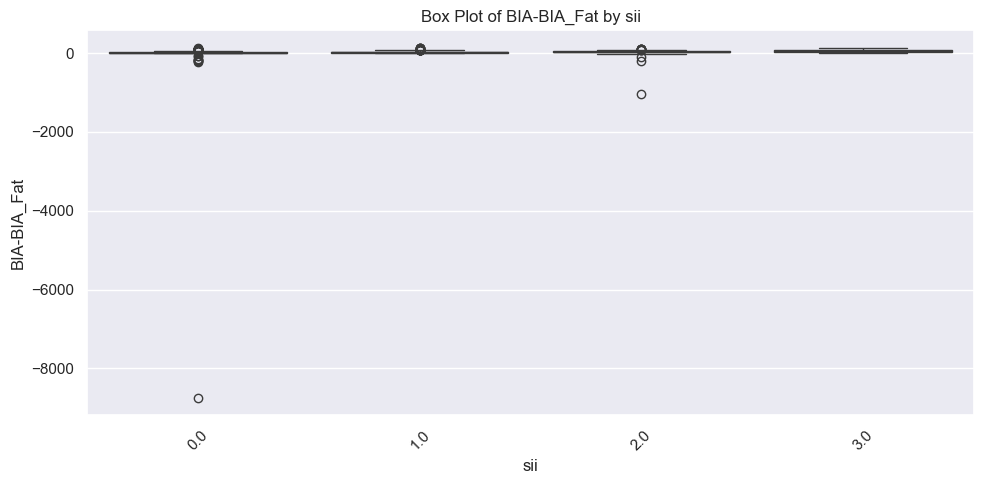

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


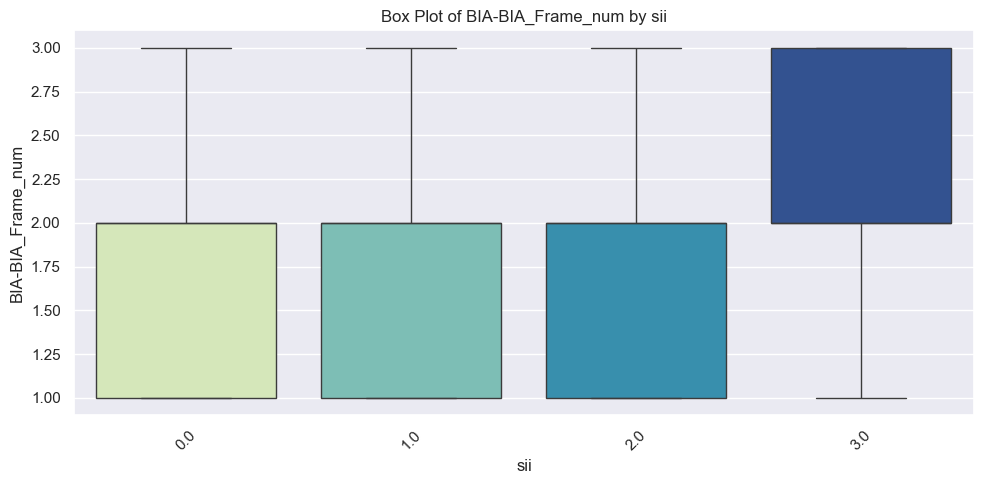

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


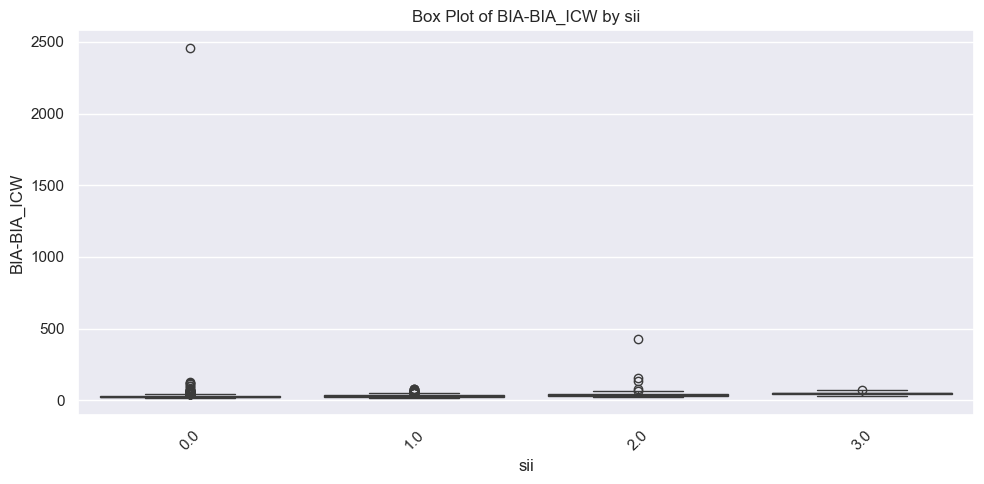

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


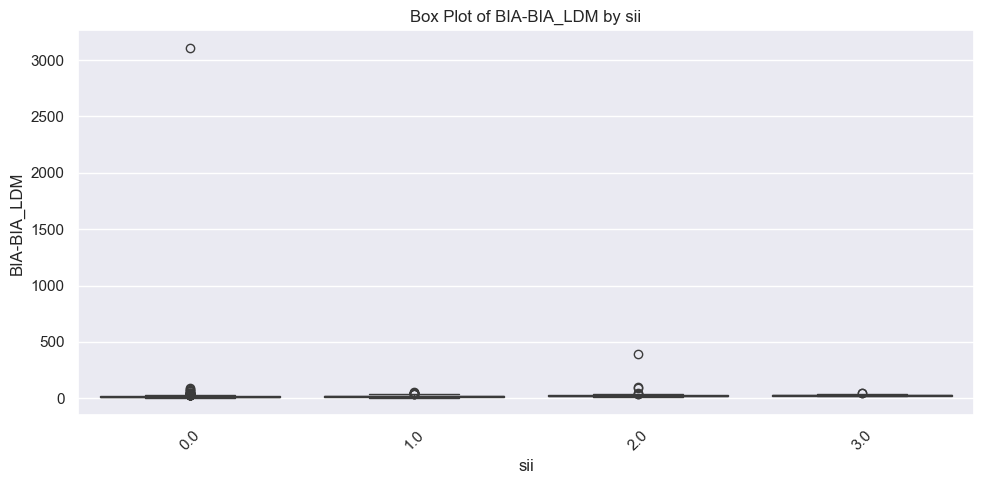

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


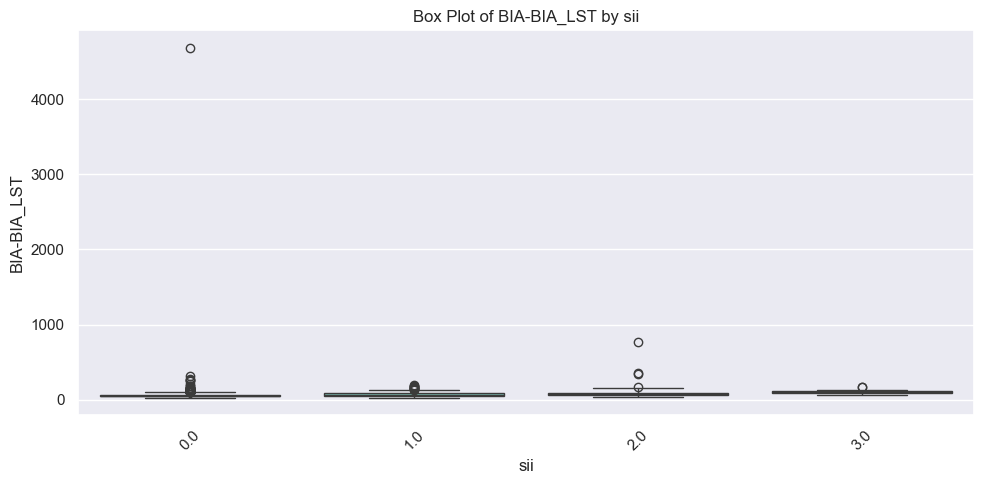

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


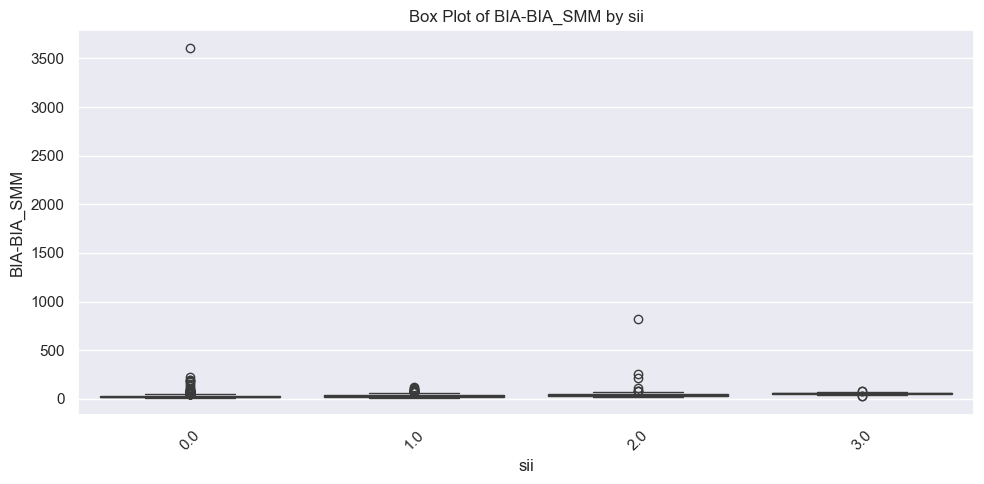

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


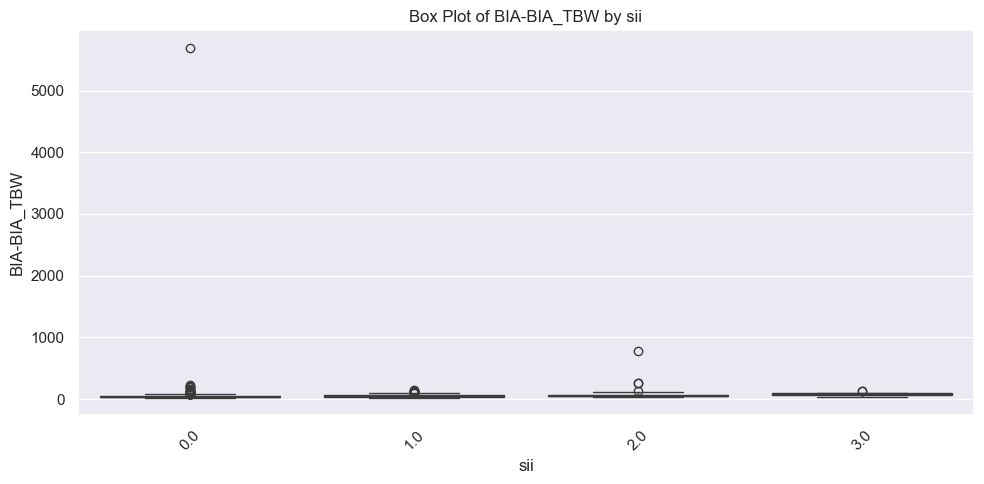

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


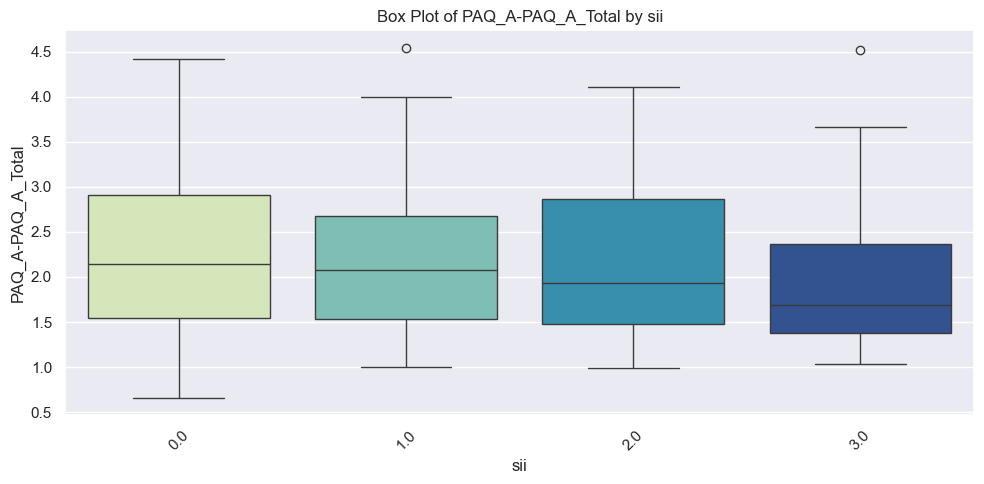

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


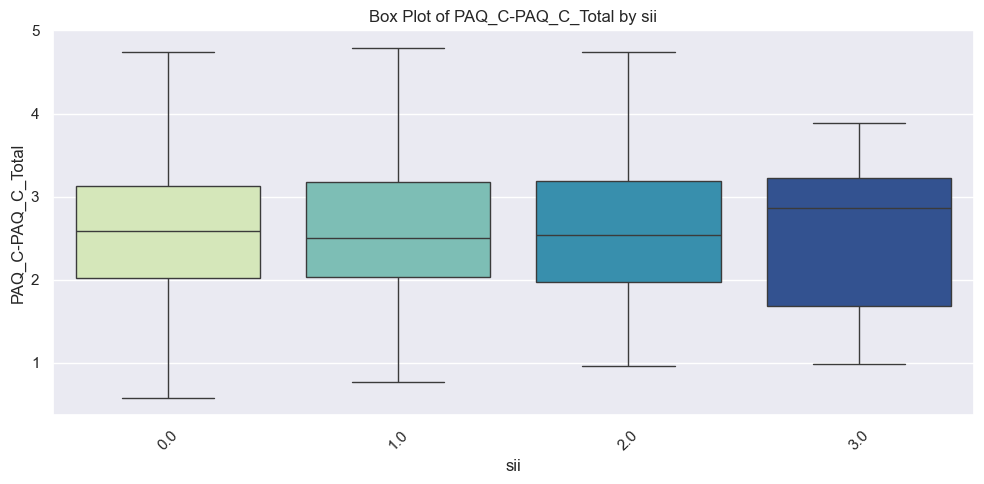

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


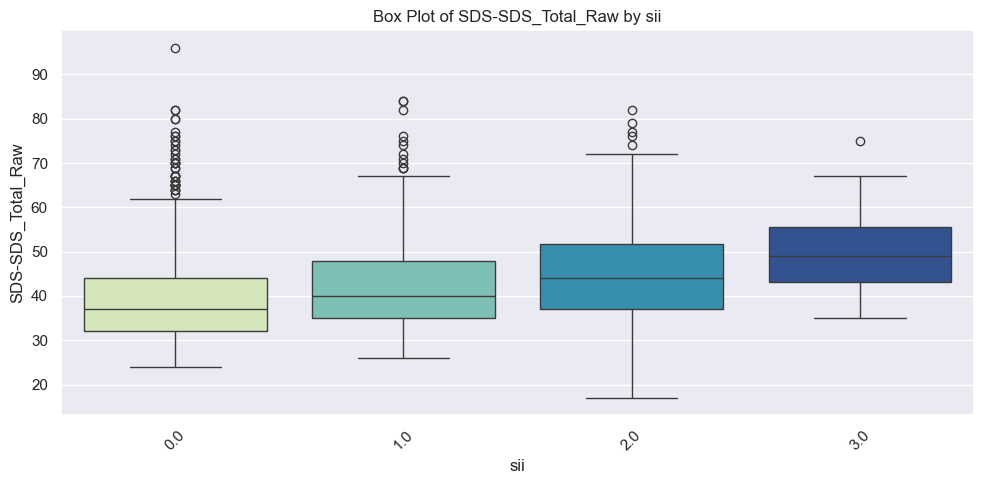

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


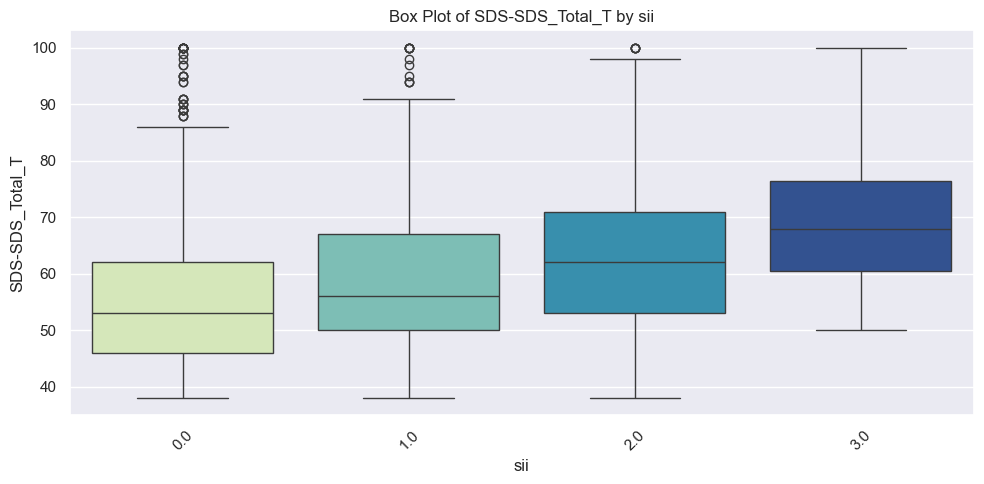

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\834722757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )


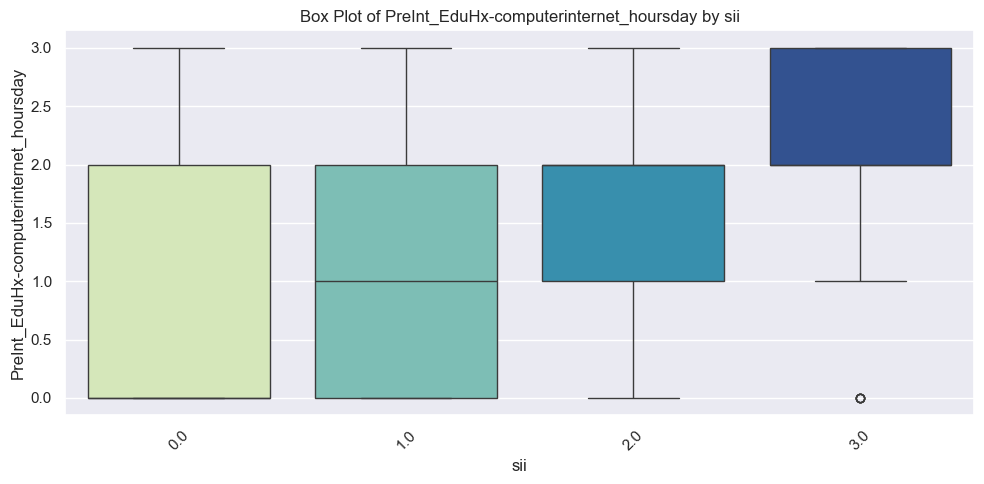

In [18]:
for column in continnum_data.columns:
    if column != 'sii':
        plt.figure(figsize=(10, 5))

        # Create a box plot
        sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu' )

        plt.title(f'Box Plot of {column} by sii')
        plt.xlabel('sii')
        plt.ylabel(column)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\3685236586.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu', ax=axes[idx])
C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\3685236586.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu', ax=axes[idx])
C:\Users\johnn\AppData\Local\Temp\ipykernel_25172\3685236586.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu', ax=

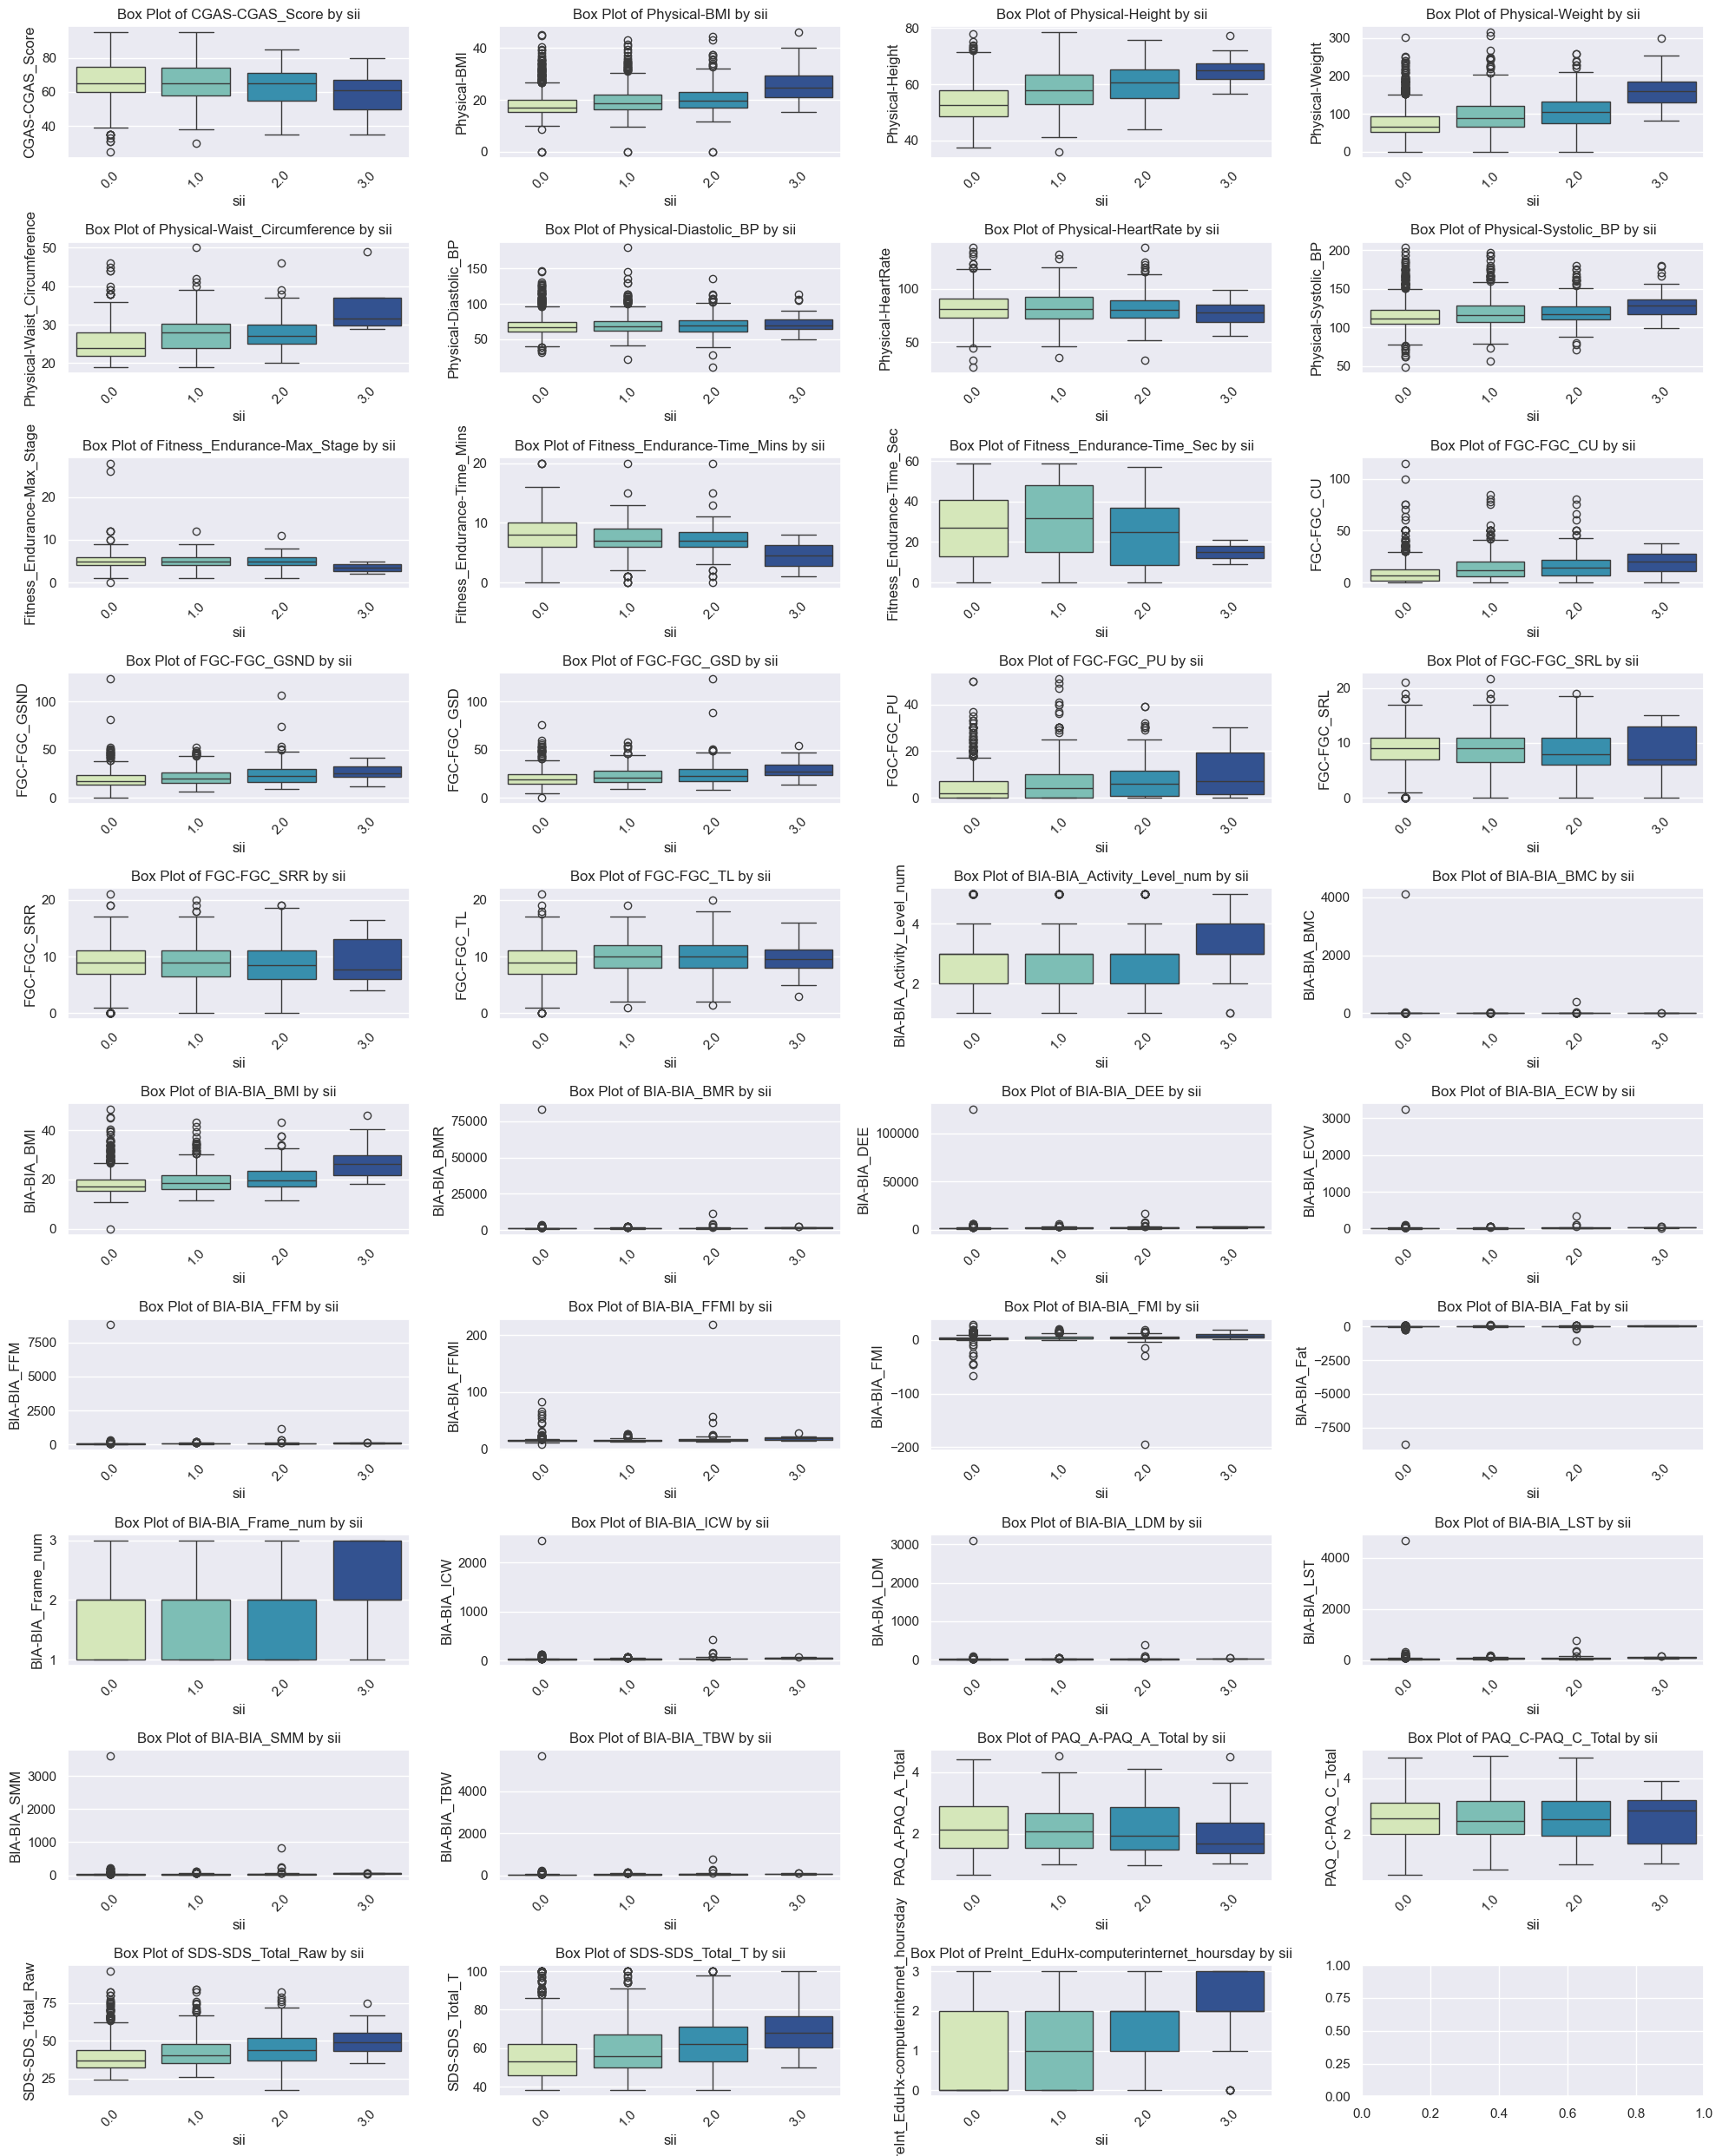

In [19]:
num_columns = len(continnum_data.columns) - 1  # Exclude 'sii'
num_rows = 10
num_cols = 4

# Create a figure with a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each column and create box plots
for idx, column in enumerate(continnum_data.columns):
    if column != 'sii':
        sns.boxplot(x='sii', y=column, data=continnum_data, palette='YlGnBu', ax=axes[idx])
        axes[idx].set_title(f'Box Plot of {column} by sii')
        axes[idx].set_xlabel('sii')
        axes[idx].set_ylabel(column)
        axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(idx + 1, num_rows * num_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('box_plots_matrix.png', dpi=300)
plt.show()

In [20]:
variance_dict = {}
for column in continnum_data.columns:
    if column != 'sii':  # Exclude the 'sii' column
        # Calculate variance for each group defined by 'sii'
        variance_per_group = continnum_data.groupby('sii')[column].var()
        variance_dict[column] = variance_per_group
variance_df = pd.DataFrame(variance_dict)
print(variance_df)

     CGAS-CGAS_Score  Physical-BMI  Physical-Height  Physical-Weight  \
sii                                                                    
0.0       141.994226     19.808086        46.966364      1447.345082   
1.0       138.429016     25.456230        50.039096      2008.409359   
2.0       124.542598     27.072977        43.459003      1849.316585   
3.0       130.322660     50.195219        17.734602      2487.188712   

     Physical-Waist_Circumference  Physical-Diastolic_BP  Physical-HeartRate  \
sii                                                                            
0.0                     21.904847             184.606571          184.761735   
1.0                     30.884735             201.923459          207.817670   
2.0                     28.157475             186.428261          181.873222   
3.0                     86.916667             202.683712          101.996212   

     Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
sii                         